In [1]:

import os
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import albumentations as A
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/tumor'

for filename in os.listdir(folder_path):
  print(filename)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Mounted at /content/drive
glioma
meningioma
pituitary
no


SEGMENTATION AND FEATURE EXTRACTION

In [3]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.3 MB/s eta 0:00:00


In [4]:

import skfuzzy as fuzz
from skimage.feature import graycomatrix, graycoprops

# Define the folder path
folder_path = '/content/drive/MyDrive/tumor/glioma'

# Initialize a list to store GLCM features
gglcm_features_list = []

def extract_glcm_features(image):
    # Compute GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract features
    features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }
    return features

# Counter for processed images
processed_count = 0
max_process = 700

for filename in os.listdir(folder_path):
    if processed_count >= max_process:
        break  # Stop processing if the limit is reached

    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Normalization
            resize = cv2.resize(image, (224, 224))
            normalized_image = resize / 255.0

            # Histogram Equalization
            gray_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
            equalized_image = cv2.equalizeHist(gray_image)

            # Adaptive Contrast Enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(equalized_image)

            # Adaptive Gamma Correction
            gamma = 1.5
            gamma_corrected_image = np.power(enhanced_image / 255.0, gamma) * 255.0
            gamma_corrected_image = gamma_corrected_image.astype(np.uint8)

            # Data Augmentation (example with horizontal flip)
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
            ])
            augmented_image = transform(image=gamma_corrected_image)['image']

            # Median Filtering
            median_filtered_image = cv2.medianBlur(augmented_image, 5)  # Adjust kernel size as needed

            # Apply Fuzzy C-Means clustering
            # Reshape the image to a 2D array of pixels
            pixel_values = median_filtered_image.reshape((-1, 1))
            pixel_values = pixel_values.astype(float)

            # Perform FCM clustering
            n_clusters = 3
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                pixel_values.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

            # Get the cluster label with the highest membership
            cluster_membership = np.argmax(u, axis=0)
            segmented_image = cluster_membership.reshape(median_filtered_image.shape)

            # Convert the segmented image to a binary image for visualization
            binary_segmented_image = (segmented_image == 1).astype(np.uint8) * 255

            # Extract GLCM features from the grayscale version of the median filtered image
            glcm_features = extract_glcm_features(median_filtered_image)
            gglcm_features_list.append(glcm_features)

            # Display the result
            cv2_imshow(binary_segmented_image)
            print(f"Processed and extracted features from {filename}")
            print(glcm_features)

            # Increment the processed images counter
            processed_count += 1

        else:
            print(f"Failed to load image: {filename}")

# Optionally, process the list of GLCM features
print(f"Extracted GLCM features for {len(gglcm_features_list)} images.")


Output hidden; open in https://colab.research.google.com to view.

In [5]:

from skimage.feature import graycomatrix, graycoprops

# Define the folder path
folder_path = '/content/drive/MyDrive/tumor/meningioma'

# Initialize a list to store GLCM features
mglcm_features_list = []

def extract_glcm_features(image):
    # Compute GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract features
    features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }
    return features

# Counter for processed images
processed_count = 0
max_process = 700

for filename in os.listdir(folder_path):
    if processed_count >= max_process:
        break  # Stop processing if the limit is reached

    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Normalization
            resize = cv2.resize(image, (224, 224))
            normalized_image = resize / 255.0


            # Histogram Equalization
            gray_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
            equalized_image = cv2.equalizeHist(gray_image)

            # Adaptive Contrast Enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(equalized_image)

            # Adaptive Gamma Correction
            gamma = 1.5
            gamma_corrected_image = np.power(enhanced_image / 255.0, gamma) * 255.0
            gamma_corrected_image = gamma_corrected_image.astype(np.uint8)

            # Data Augmentation (example with horizontal flip)
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
            ])
            augmented_image = transform(image=gamma_corrected_image)['image']

            # Median Filtering
            median_filtered_image = cv2.medianBlur(augmented_image, 5)  # Adjust kernel size as needed
            # Apply Fuzzy C-Means clustering
            # Reshape the image to a 2D array of pixels
            pixel_values = median_filtered_image.reshape((-1, 1))
            pixel_values = pixel_values.astype(float)

            # Perform FCM clustering
            n_clusters = 3
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                pixel_values.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

            # Get the cluster label with the highest membership
            cluster_membership = np.argmax(u, axis=0)
            segmented_image = cluster_membership.reshape(median_filtered_image.shape)

            # Convert the segmented image to a binary image for visualization
            binary_segmented_image = (segmented_image == 1).astype(np.uint8) * 255

            # Extract GLCM features from the grayscale version of the median filtered image
            glcm_features = extract_glcm_features(median_filtered_image)
            mglcm_features_list.append(glcm_features)
            print(glcm_features)

            # Display the result if display_count is less than max_display
            if processed_count < max_process:
                cv2_imshow(binary_segmented_image)
                print(f"Processed and extracted features from {filename}")
                processed_count += 1

        else:
            print(f"Failed to load image: {filename}")

# Optionally, process the list of GLCM features
print(f"Extracted GLCM features for {len(mglcm_features_list)} images.")


Output hidden; open in https://colab.research.google.com to view.

In [6]:

from skimage.feature import graycomatrix, graycoprops
import skfuzzy as fuzz
# Define the folder path
folder_path = '/content/drive/MyDrive/tumor/no'

# Initialize a list to store GLCM features
nglcm_features_list = []

def extract_glcm_features(image):
    # Compute GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract features
    features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }
    return features

# Counter for processed images
processed_count = 0
max_process = 700

for filename in os.listdir(folder_path):
    if processed_count >= max_process:
        break  # Stop processing if the limit is reached

    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Normalization
            resize = cv2.resize(image, (224, 224))
            normalized_image = resize / 255.0

            # Histogram Equalization
            gray_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
            equalized_image = cv2.equalizeHist(gray_image)

            # Adaptive Contrast Enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(equalized_image)

            # Adaptive Gamma Correction
            gamma = 1.5
            gamma_corrected_image = np.power(enhanced_image / 255.0, gamma) * 255.0
            gamma_corrected_image = gamma_corrected_image.astype(np.uint8)

            # Data Augmentation (example with horizontal flip)
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
            ])
            augmented_image = transform(image=gamma_corrected_image)['image']

            # Median Filtering
            median_filtered_image = cv2.medianBlur(augmented_image, 5)  # Adjust kernel size as needed
            # Apply Fuzzy C-Means clustering
            # Reshape the image to a 2D array of pixels
            pixel_values = median_filtered_image.reshape((-1, 1))
            pixel_values = pixel_values.astype(float)

            # Perform FCM clustering
            n_clusters = 3
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                pixel_values.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

            # Get the cluster label with the highest membership
            cluster_membership = np.argmax(u, axis=0)
            segmented_image = cluster_membership.reshape(median_filtered_image.shape)

            # Convert the segmented image to a binary image for visualization
            binary_segmented_image = (segmented_image == 1).astype(np.uint8) * 255

            # Extract GLCM features from the grayscale version of the median filtered image
            glcm_features = extract_glcm_features(median_filtered_image)
            nglcm_features_list.append(glcm_features)
            print(glcm_features)

            # Display the result if display_count is less than max_display
            if processed_count < max_process:
                cv2_imshow(median_filtered_image)
                cv2_imshow(binary_segmented_image)
                print(f"Processed and extracted features from {filename}")
                processed_count += 1

        else:
            print(f"Failed to load image: {filename}")

# Optionally, process the list of GLCM features
print(f"Extracted GLCM features for {len(nglcm_features_list)} images.")


Output hidden; open in https://colab.research.google.com to view.

In [7]:

from skimage.feature import graycomatrix, graycoprops

# Define the folder path
folder_path = '/content/drive/MyDrive/tumor/pituitary'

# Initialize a list to store GLCM features
pglcm_features_list = []

def extract_glcm_features(image):
    # Compute GLCM
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract features
    features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }
    return features

# Counter for processed images
processed_count = 0
max_process = 700

for filename in os.listdir(folder_path):
    if processed_count >= max_process:
        break  # Stop processing if the limit is reached

    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Normalization
            resize = cv2.resize(image, (224, 224))
            normalized_image = resize / 255.0

            # Histogram Equalization
            gray_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
            equalized_image = cv2.equalizeHist(gray_image)

            # Adaptive Contrast Enhancement
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(equalized_image)

            # Adaptive Gamma Correction
            gamma = 1.5
            gamma_corrected_image = np.power(enhanced_image / 255.0, gamma) * 255.0
            gamma_corrected_image = gamma_corrected_image.astype(np.uint8)

            # Data Augmentation (example with horizontal flip)
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
            ])
            augmented_image = transform(image=gamma_corrected_image)['image']

            # Median Filtering
            median_filtered_image = cv2.medianBlur(augmented_image, 5)  # Adjust kernel size as needed

            # Apply Fuzzy C-Means clustering
            # Reshape the image to a 2D array of pixels
            pixel_values = median_filtered_image.reshape((-1, 1))
            pixel_values = pixel_values.astype(float)

            # Perform FCM clustering
            n_clusters = 3
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                pixel_values.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)

            # Get the cluster label with the highest membership
            cluster_membership = np.argmax(u, axis=0)
            segmented_image = cluster_membership.reshape(median_filtered_image.shape)

            # Convert the segmented image to a binary image for visualization
            binary_segmented_image = (segmented_image == 1).astype(np.uint8) * 255

            # Extract GLCM features from the grayscale version of the median filtered image
            glcm_features = extract_glcm_features(median_filtered_image)
            pglcm_features_list.append(glcm_features)
            print(glcm_features)

            # Display the result if display_count is less than max_display
            if processed_count < max_process:
                cv2_imshow(binary_segmented_image)
                print(f"Processed and extracted features from {filename}")
                processed_count += 1

        else:
            print(f"Failed to load image: {filename}")

# Optionally, process the list of GLCM features
print(f"Extracted GLCM features for {len(pglcm_features_list)} images.")


Output hidden; open in https://colab.research.google.com to view.

In [8]:
# prompt: combine all the above extracted features and split the above processed dataset into testing,training and validation

import pandas as pd
from sklearn.model_selection import train_test_split

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Split the data
X = df.drop('label', axis=1)
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


Model training

VGG-16

In [9]:
import os
import cv2
import numpy as np
import albumentations as A
import skfuzzy as fuzz
from google.colab.patches import cv2_imshow
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data to fit VGG-like model (1D convolution)
# Assume we reshape into 1D "pseudo-images" with one channel
X_train_reshape = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshape = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshape = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define a VGG-like model for 1D data
def create_vgg_like_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))  # 4 output classes
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train the model
vgg_like_model = create_vgg_like_model((X_train_reshape.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = vgg_like_model.fit(X_train_reshape, y_train,
                             epochs=100,
                             batch_size=32,
                             validation_data=(X_val_reshape, y_val),
                             callbacks=[early_stopping, reduce_lr])

# Evaluate the model
vggtrain_loss, vggtrain_accuracy = vgg_like_model.evaluate(X_train_reshape, y_train, verbose=0)
vggval_loss, vggval_accuracy = vgg_like_model.evaluate(X_val_reshape, y_val, verbose=0)
vggtest_loss, vggtest_accuracy = vgg_like_model.evaluate(X_test_reshape, y_test, verbose=0)

print(f"Training Accuracy: {vggtrain_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {vggval_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {vggtest_accuracy * 100:.2f}%")




Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5180 - loss: 1.1436 - val_accuracy: 0.4000 - val_loss: 1.1496 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6826 - loss: 0.8159 - val_accuracy: 0.7286 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7505 - loss: 0.6213 - val_accuracy: 0.8095 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8153 - loss: 0.5036 - val_accuracy: 0.7286 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8090 - loss: 0.5103 - val_accuracy: 0.8214 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8443 - loss: 0.4283 - val_accuracy: 0.8167 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8344 - loss: 0.4208 - 

Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9656 - loss: 0.1124 - val_accuracy: 0.9262 - val_loss: 0.2086 - learning_rate: 1.0000e-05
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9643 - loss: 0.1091 - val_accuracy: 0.9214 - val_loss: 0.2090 - learning_rate: 1.0000e-05
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9522 - loss: 0.1163 - val_accuracy: 0.9190 - val_loss: 0.2097 - learning_rate: 1.0000e-05
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9662 - loss: 0.1020 - val_accuracy: 0.9238 - val_loss: 0.2095 - learning_rate: 1.0000e-05
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9558 - loss: 0.1145 - val_accuracy: 0.9167 - val_loss: 0.2108 - learning_rate: 1.0000e-05
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9555 - loss: 0.1146 - val_accuracy: 0.9190 - val_loss: 0.2109 - learning_rate: 1.0000e-05
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 

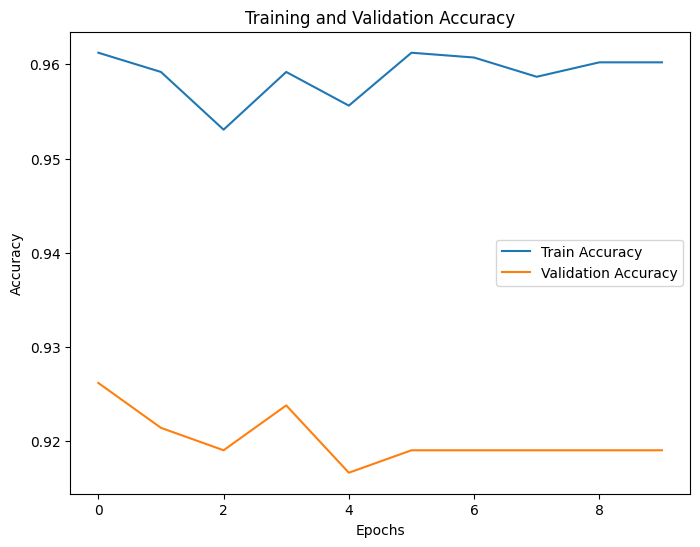

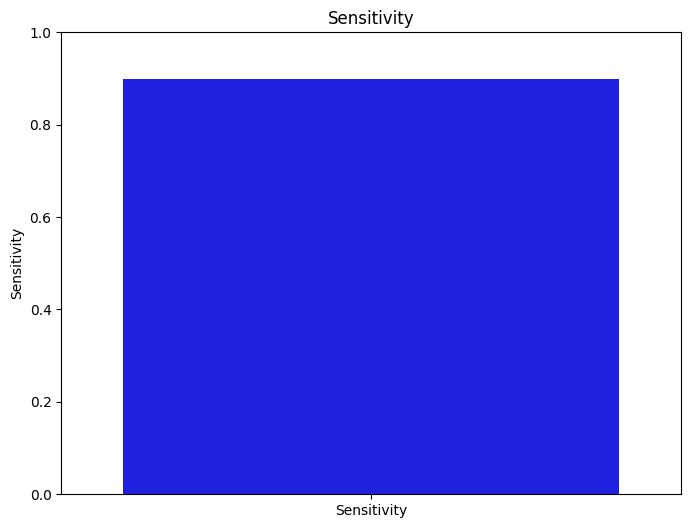

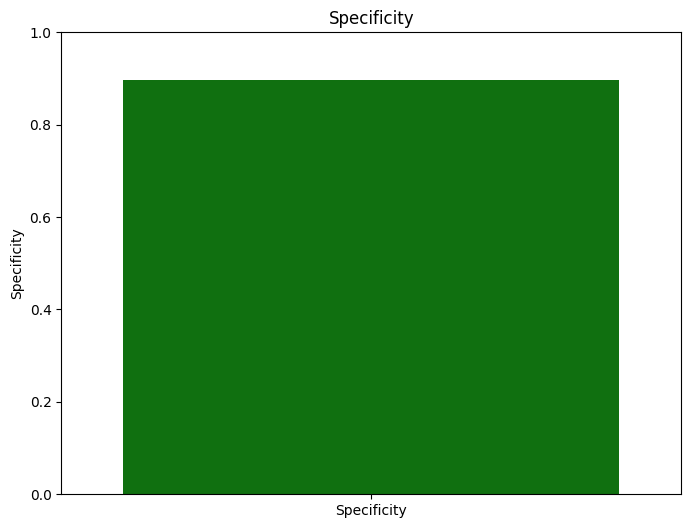

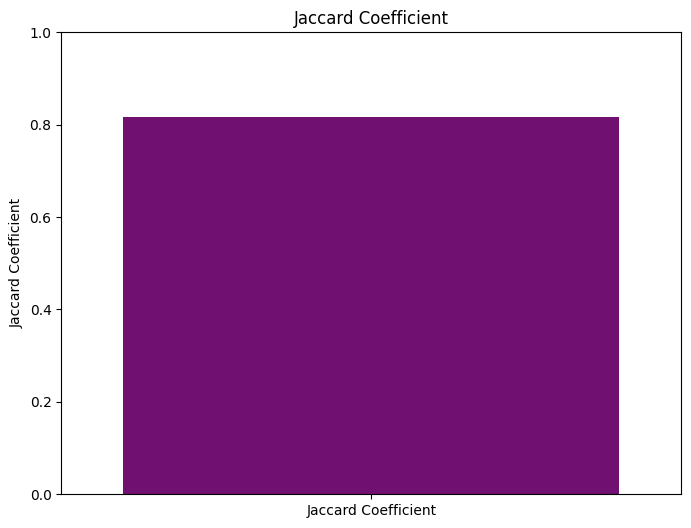

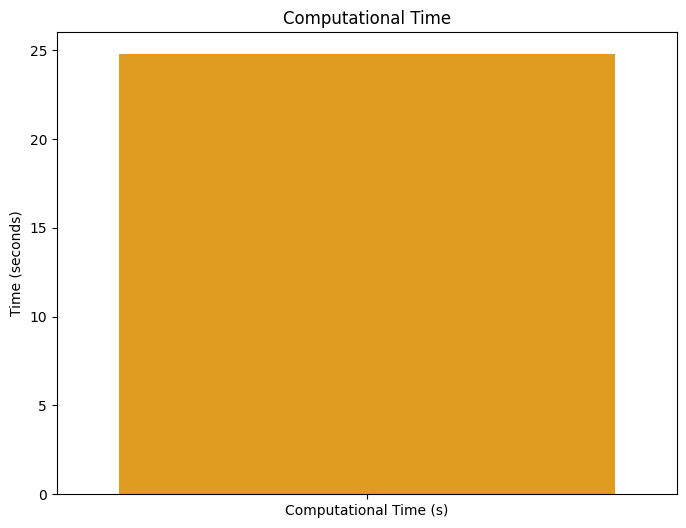

In [10]:
import time
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt


# Start the timer to track computational time
start_time = time.time()

# Train the model
history = vgg_like_model.fit(X_train_reshape, y_train,
                             epochs=100,
                             batch_size=32,
                             validation_data=(X_val_reshape, y_val),
                             callbacks=[early_stopping, reduce_lr])

# End the timer
end_time = time.time()
computational_time = end_time - start_time

# Evaluate the model on the test set
y_pred = vgg_like_model.predict(X_test_reshape)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sensitivity = recall_score(y_test, y_pred_classes, average='macro')
specificity = precision_score(y_test, y_pred_classes, average='macro')
jaccard = jaccard_score(y_test, y_pred_classes, average='macro')

# Print the computed metrics
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Jaccard Coefficient: {jaccard:.4f}")
print(f"Computational Time: {computational_time:.2f} seconds")


# Plot the accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the sensitivity (recall)
plt.figure(figsize=(8, 6))
sns.barplot(x=['Sensitivity'], y=[sensitivity], color='blue')
plt.ylim(0, 1)
plt.ylabel('Sensitivity')
plt.title('Sensitivity')
plt.show()

# Plot the specificity (precision)
plt.figure(figsize=(8, 6))
sns.barplot(x=['Specificity'], y=[specificity], color='green')
plt.ylim(0, 1)
plt.ylabel('Specificity')
plt.title('Specificity')
plt.show()

# Plot the Jaccard coefficient
plt.figure(figsize=(8, 6))
sns.barplot(x=['Jaccard Coefficient'], y=[jaccard], color='purple')
plt.ylim(0, 1)
plt.ylabel('Jaccard Coefficient')
plt.title('Jaccard Coefficient')
plt.show()

# Plot the computational time
plt.figure(figsize=(8, 6))
sns.barplot(x=['Computational Time (s)'], y=[computational_time], color='orange')
plt.ylabel('Time (seconds)')
plt.title('Computational Time')
plt.show()


ANN

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4833 - loss: 1.1926 - val_accuracy: 0.6738 - val_loss: 0.8443
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6389 - loss: 0.8594 - val_accuracy: 0.7738 - val_loss: 0.6480
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7037 - loss: 0.7448 - val_accuracy: 0.7714 - val_loss: 0.5953
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7191 - loss: 0.6810 - val_accuracy: 0.7262 - val_loss: 0.6459
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7440 - loss: 0.6567 - val_accuracy: 0.7690 - val_loss: 0.5788
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7483 - loss: 0.6330 - val_accuracy: 0.7810 - val_loss: 0.5624
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7603 - loss: 0.6288 - val_accuracy: 0.8310 - val_loss: 0.5075
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7738 - loss: 0.5724 - val_accuracy: 0.8476 - val_loss: 0.

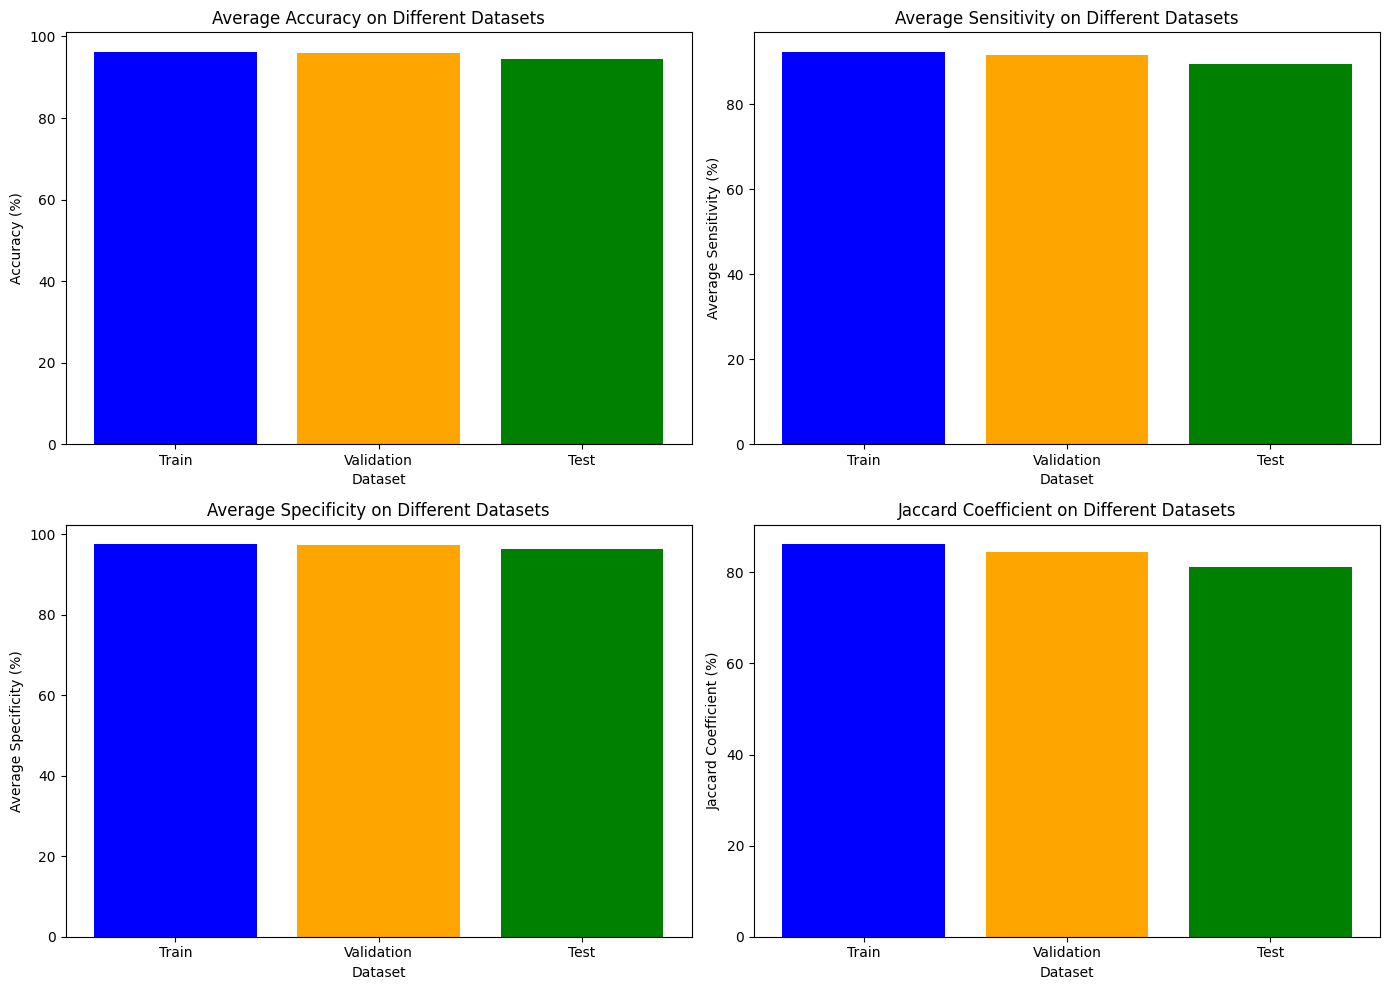

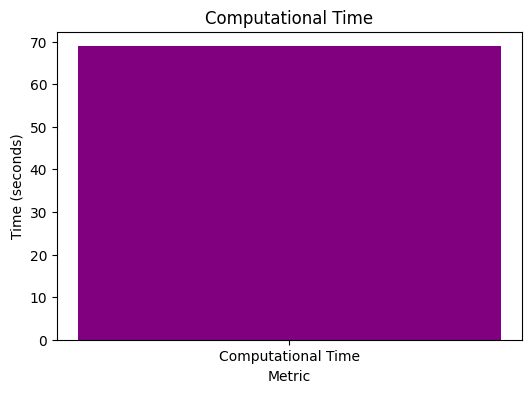

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Split the data
X = df.drop('label', axis=1)
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model
def create_ann_model(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # 4 output classes
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train ANN
ann_model = create_ann_model(X_train_scaled.shape[1])

# Start the timer for training
start_time = time.time()

history = ann_model.fit(X_train_scaled, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_val_scaled, y_val))

# End the timer for training
end_time = time.time()
computational_time = end_time - start_time

# Evaluate ANN
y_pred_train = np.argmax(ann_model.predict(X_train_scaled), axis=-1)
y_pred_val = np.argmax(ann_model.predict(X_val_scaled), axis=-1)
y_pred_test = np.argmax(ann_model.predict(X_test_scaled), axis=-1)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return accuracy, sensitivity, specificity, jaccard

train_accuracy, train_sensitivity, train_specificity, train_jaccard = calculate_metrics(y_train, y_pred_train)
val_accuracy, val_sensitivity, val_specificity, val_jaccard = calculate_metrics(y_val, y_pred_val)
test_accuracy, test_sensitivity, test_specificity, test_jaccard = calculate_metrics(y_test, y_pred_test)

# Calculate average metrics
avg_train_accuracy = train_accuracy
avg_val_accuracy = val_accuracy
avg_test_accuracy = test_accuracy

avg_train_sensitivity = np.mean(train_sensitivity)
avg_val_sensitivity = np.mean(val_sensitivity)
avg_test_sensitivity = np.mean(test_sensitivity)

avg_train_specificity = np.mean(train_specificity)
avg_val_specificity = np.mean(val_specificity)
avg_test_specificity = np.mean(test_specificity)

avg_train_jaccard = train_jaccard
avg_val_jaccard = val_jaccard
avg_test_jaccard = test_jaccard
print(f"Training Accuracy: {np.mean(train_accuracy) * 100:.2f}%")
print(f"Validation Accuracy: {np.mean(val_accuracy) * 100:.2f}%")
print(f"Testing Accuracy: {np.mean(test_accuracy) * 100:.2f}%")
print(f"Training Jaccard Coefficient: {train_jaccard:.2f}")
print(f"Validation Jaccard Coefficient: {val_jaccard:.2f}")
print(f"Testing Jaccard Coefficient: {test_jaccard:.2f}")
print(f"Training Sensitivity: {train_sensitivity}")
print(f"Validation Sensitivity: {val_sensitivity}")
print(f"Testing Sensitivity: {test_sensitivity}")
print(f"Training Specificity: {train_specificity}")
print(f"Validation Specificity: {val_specificity}")
print("computational time",computational_time )


# Plot Metrics

plt.figure(figsize=(14, 10))

# Plot Average Accuracy
plt.subplot(2, 2, 1)
plt.bar(['Train', 'Validation', 'Test'],
        [np.mean(avg_train_accuracy) * 100, np.mean(avg_val_accuracy) * 100, np.mean(avg_test_accuracy) * 100],
        color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('Average Accuracy on Different Datasets')

# Plot Average Sensitivity
plt.subplot(2, 2, 2)
plt.bar(['Train', 'Validation', 'Test'], [avg_train_sensitivity * 100, avg_val_sensitivity * 100, avg_test_sensitivity * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Average Sensitivity (%)')
plt.title('Average Sensitivity on Different Datasets')

# Plot Average Specificity
plt.subplot(2, 2, 3)
plt.bar(['Train', 'Validation', 'Test'], [avg_train_specificity * 100, avg_val_specificity * 100, avg_test_specificity * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Average Specificity (%)')
plt.title('Average Specificity on Different Datasets')

# Plot Average Jaccard Coefficient
plt.subplot(2, 2, 4)
plt.bar(['Train', 'Validation', 'Test'], [avg_train_jaccard * 100, avg_val_jaccard * 100, avg_test_jaccard * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Jaccard Coefficient (%)')
plt.title('Jaccard Coefficient on Different Datasets')

plt.tight_layout()
plt.show()

# Plot Computational Time
plt.figure(figsize=(6, 4))
plt.bar(['Computational Time'], [computational_time], color='purple')
plt.xlabel('Metric')
plt.ylabel('Time (seconds)')
plt.title('Computational Time')
plt.show()


RFC

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


<ipython-input-12-3ccab8a40f24>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_labels, y=accuracies, palette='Blues')


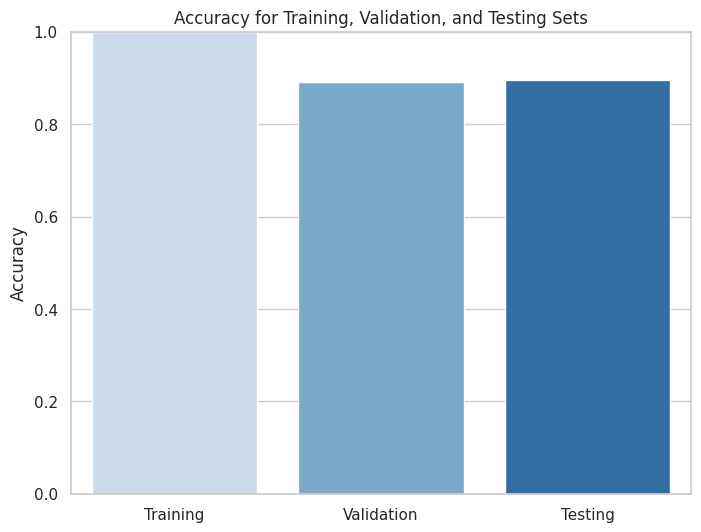

<ipython-input-12-3ccab8a40f24>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_labels, y=jaccard_coefficients, palette='Purples')


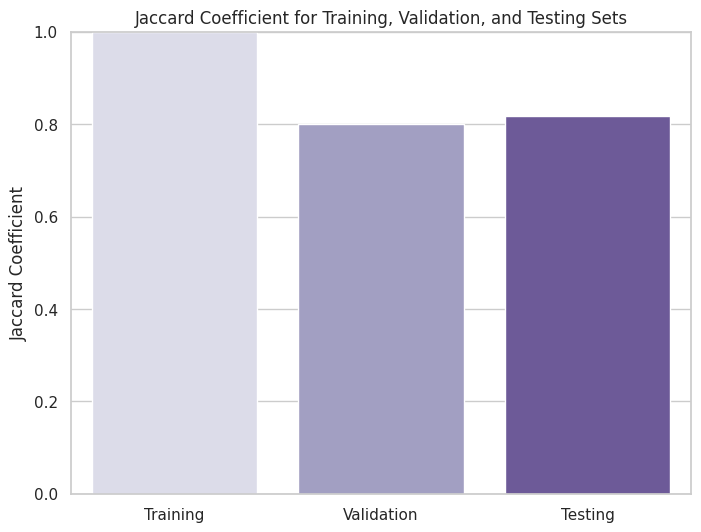

<ipython-input-12-3ccab8a40f24>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_labels, y=sensitivities, palette='Greens')


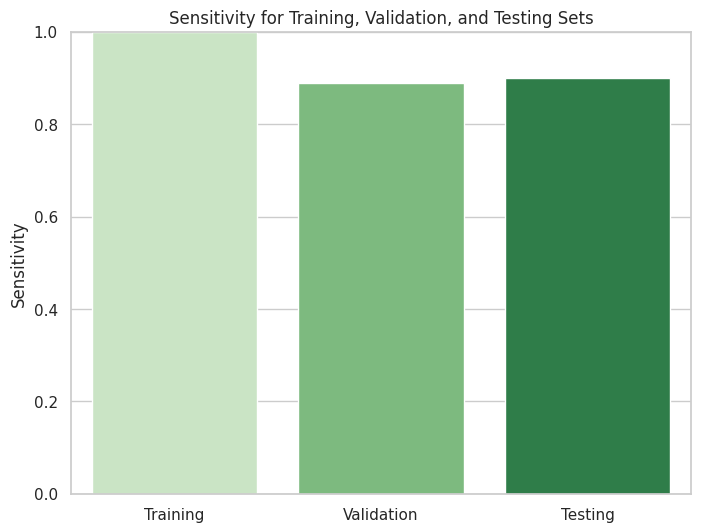

<ipython-input-12-3ccab8a40f24>:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_labels, y=specificities, palette='Oranges')


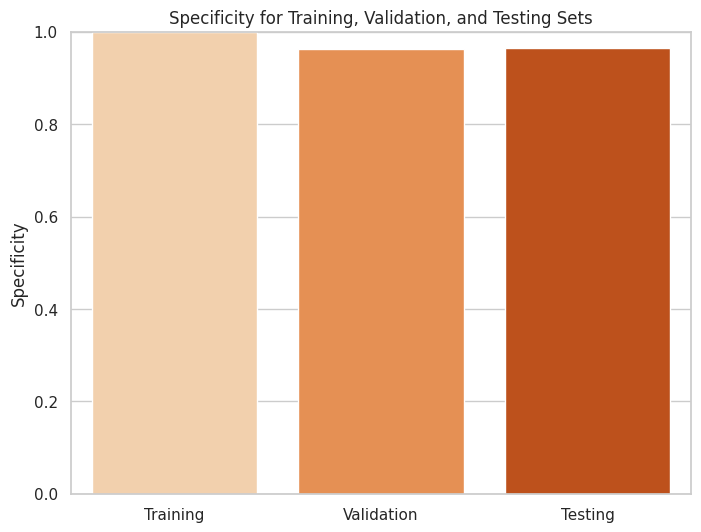

<ipython-input-12-3ccab8a40f24>:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Computational Time'], y=[computational_time], palette='Reds')


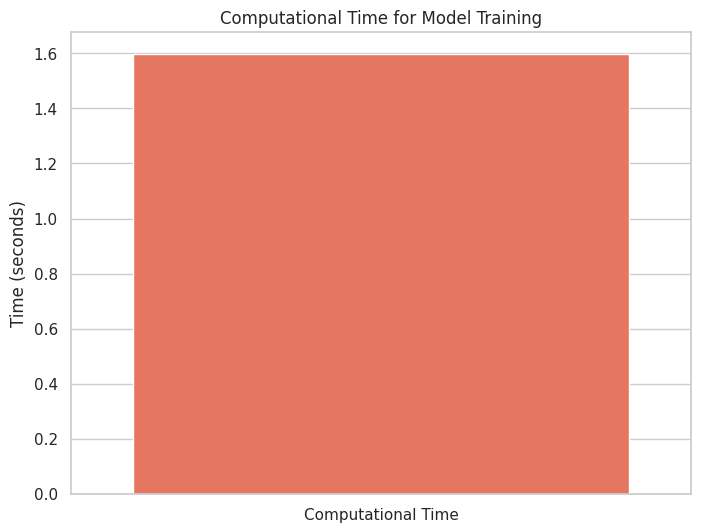

In [12]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Split the data
X = df.drop('label', axis=1)
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Train the Random Forest Classifier and measure computational time
start_time = time.time()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(X_train, y_train_encoded)
end_time = time.time()
computational_time = end_time - start_time

# Evaluate the model
y_pred_train = rfc_model.predict(X_train)
y_pred_val = rfc_model.predict(X_val)
y_pred_test = rfc_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
val_accuracy = accuracy_score(y_val_encoded, y_pred_val)
test_accuracy = accuracy_score(y_test_encoded, y_pred_test)

train_jaccard = jaccard_score(y_train_encoded, y_pred_train, average='macro')
val_jaccard = jaccard_score(y_val_encoded, y_pred_val, average='macro')
test_jaccard = jaccard_score(y_test_encoded, y_pred_test, average='macro')

def sensitivity_specificity(y_true, y_pred):
    ccm = confusion_matrix(y_true, y_pred)
    tp = np.diag(ccm)
    fp = ccm.sum(axis=0) - tp
    fn = ccm.sum(axis=1) - tp
    tn = ccm.sum() - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return np.mean(sensitivity), np.mean(specificity)

sensitivity_train, specificity_train = sensitivity_specificity(y_train_encoded, y_pred_train)
sensitivity_val, specificity_val = sensitivity_specificity(y_val_encoded, y_pred_val)
sensitivity_test, specificity_test = sensitivity_specificity(y_test_encoded, y_pred_test)

# Plot the metrics individually
sns.set(style="whitegrid")

# Plot Accuracy
plt.figure(figsize=(8, 6))
accuracies = [train_accuracy, val_accuracy, test_accuracy]
accuracy_labels = ['Training', 'Validation', 'Testing']
sns.barplot(x=accuracy_labels, y=accuracies, palette='Blues')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy for Training, Validation, and Testing Sets')
plt.show()

# Plot Jaccard Coefficient
plt.figure(figsize=(8, 6))
jaccard_coefficients = [train_jaccard, val_jaccard, test_jaccard]
sns.barplot(x=accuracy_labels, y=jaccard_coefficients, palette='Purples')
plt.ylim(0, 1)
plt.ylabel('Jaccard Coefficient')
plt.title('Jaccard Coefficient for Training, Validation, and Testing Sets')
plt.show()

# Plot Sensitivity
plt.figure(figsize=(8, 6))
sensitivities = [sensitivity_train, sensitivity_val, sensitivity_test]
sns.barplot(x=accuracy_labels, y=sensitivities, palette='Greens')
plt.ylim(0, 1)
plt.ylabel('Sensitivity')
plt.title('Sensitivity for Training, Validation, and Testing Sets')
plt.show()

# Plot Specificity
plt.figure(figsize=(8, 6))
specificities = [specificity_train, specificity_val, specificity_test]
sns.barplot(x=accuracy_labels, y=specificities, palette='Oranges')
plt.ylim(0, 1)
plt.ylabel('Specificity')
plt.title('Specificity for Training, Validation, and Testing Sets')
plt.show()

# Plot Computational Time
plt.figure(figsize=(8, 6))
sns.barplot(x=['Computational Time'], y=[computational_time], palette='Reds')
plt.ylabel('Time (seconds)')
plt.title('Computational Time for Model Training')
plt.show()


FCNNS model

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3216 - loss: 1.7680 - val_accuracy: 0.5881 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5170 - loss: 1.1936 - val_accuracy: 0.5595 - val_loss: 0.9361 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5666 - loss: 1.0647 - val_accuracy: 0.6048 - val_loss: 0.8620 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6031 - loss: 0.9523 - val_accuracy: 0.6786 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6290 - loss: 0.9118 - val_accuracy: 0.6905 - val_loss: 0.7312 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6269 - loss: 0.8805 - val_accuracy: 0.7143 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6835 - loss: 0.8049 - val_

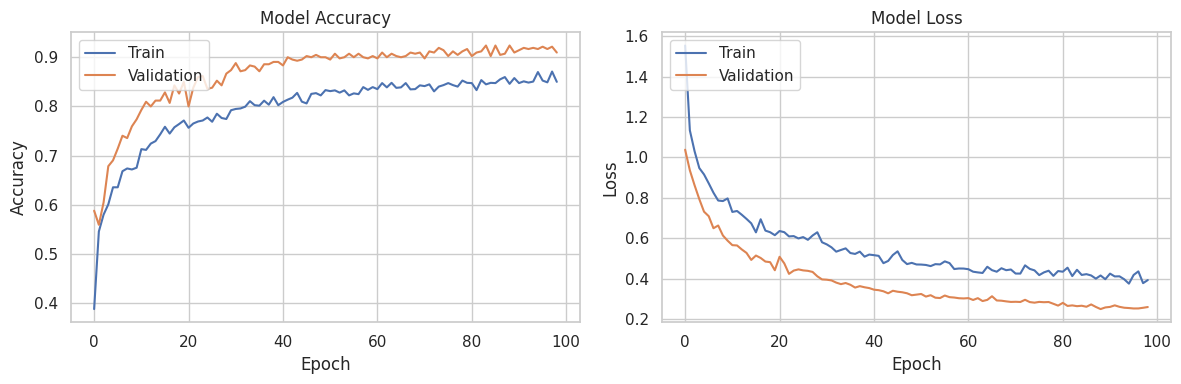

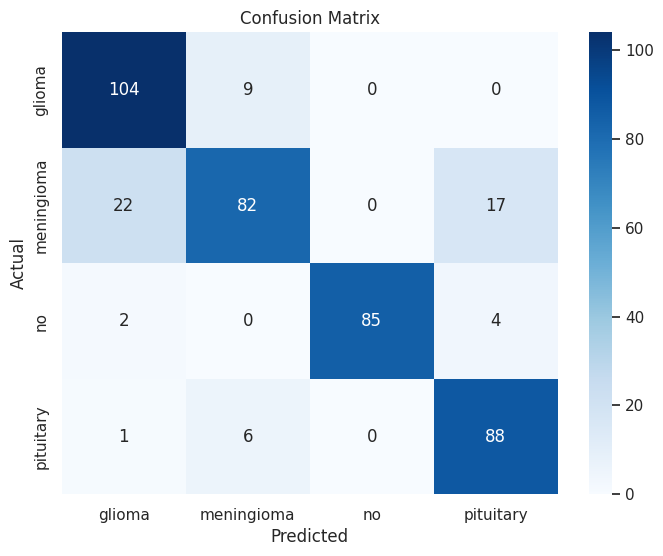

<ipython-input-13-81be23832543>:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


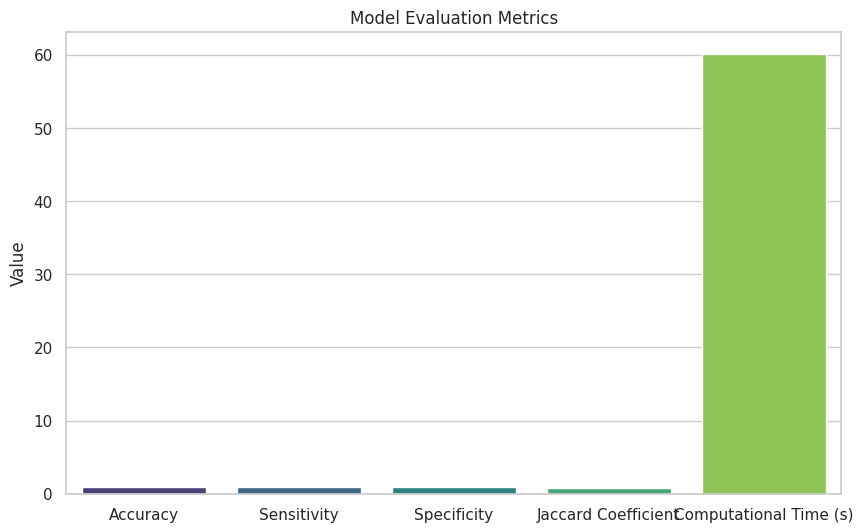

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, precision_score, recall_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)
y = df['label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Convert labels to one-hot encoding
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=4)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Define the model
def create_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))  # 4 output classes: glioma, meningioma, no, pituitary

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Create and train the model
model = create_model()

start_time = time.time()
history = model.fit(X_train, y_train_encoded,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val_encoded),
                    callbacks=[early_stopping, reduce_lr])
end_time = time.time()
training_time = end_time - start_time

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)


# Predictions
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate additional metrics
jaccard = jaccard_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

# Confusion Matrix for Sensitivity and Specificity
conf_matrix = confusion_matrix(y_true, y_pred)
tn = conf_matrix[0, 0]
tp = np.diag(conf_matrix).sum() - tn
fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
accuracy = (tp + tn) / (tp + fp + fn + tn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Accuracy:", accuracy)
print("Jaccard Coefficient:", jaccard)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot metrics individually
metrics = {
    "Accuracy": np.mean(accuracy),  # Take the mean of the accuracy array
    "Sensitivity": np.mean(sensitivity),
    "Specificity": np.mean(specificity),
    "Jaccard Coefficient": jaccard,
    "Computational Time (s)": training_time
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.show()


0.7623127471493729
0.8647254561677874
0.8646054140634316
[0.80620155 0.87394958 1.         0.832     ]
0.8647254561677874


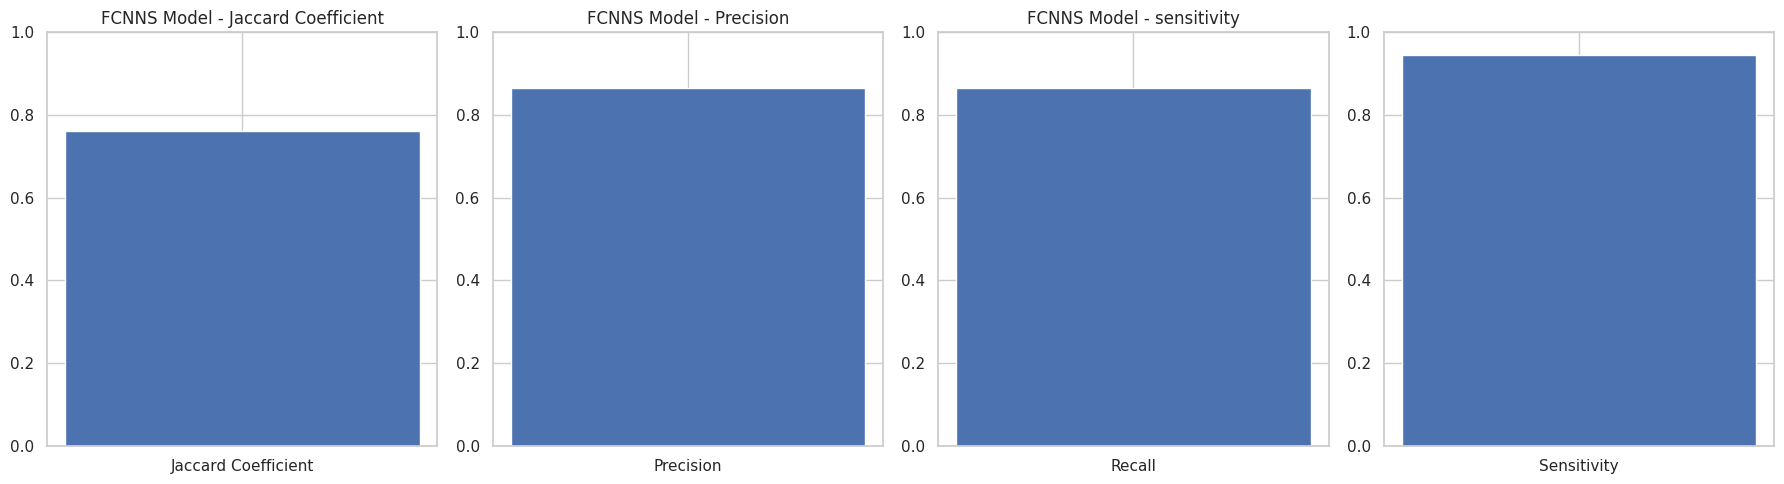

In [14]:
# Plot metrics individually
plt.figure(figsize=(18, 5))
print(jaccard)
print(precision)
print(recall)
print(specificity)
plt.subplot(1, 4, 1)
plt.bar(['Jaccard Coefficient'], [jaccard])
plt.title('FCNNS Model - Jaccard Coefficient')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
print(precision)
plt.subplot(1, 4, 2)
plt.bar(['Precision'], [precision])
plt.title('FCNNS Model - Precision') # Changed title to RNNS
plt.ylim(0, 1)

plt.subplot(1, 4, 3)
plt.bar(['Recall'], [recall])
plt.title('FCNNS Model - sensitivity') # Changed title to RNNS
plt.ylim(0, 1)

plt.subplot(1, 4, 4)
# Take the average sensitivity for plotting
avg_sensitivity = np.mean(sensitivity)
plt.bar(['Sensitivity'], [avg_sensitivity]) # Changed title to RNNS, clarified as average
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

RNNS MODEL

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4344 - loss: 1.5601 - val_accuracy: 0.2429 - val_loss: 1.3997 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5826 - loss: 1.0707 - val_accuracy: 0.2548 - val_loss: 1.3781 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6378 - loss: 0.8624 - val_accuracy: 0.2833 - val_loss: 1.3132 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6825 - loss: 0.8090 - val_accuracy: 0.3357 - val_loss: 1.1661 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6869 - loss: 0.7724 - val_accuracy: 0.4405 - val_loss: 1.0200 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6932 - loss: 0.7388 - val_accuracy: 0.6524 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7230 - loss: 0.6909 -

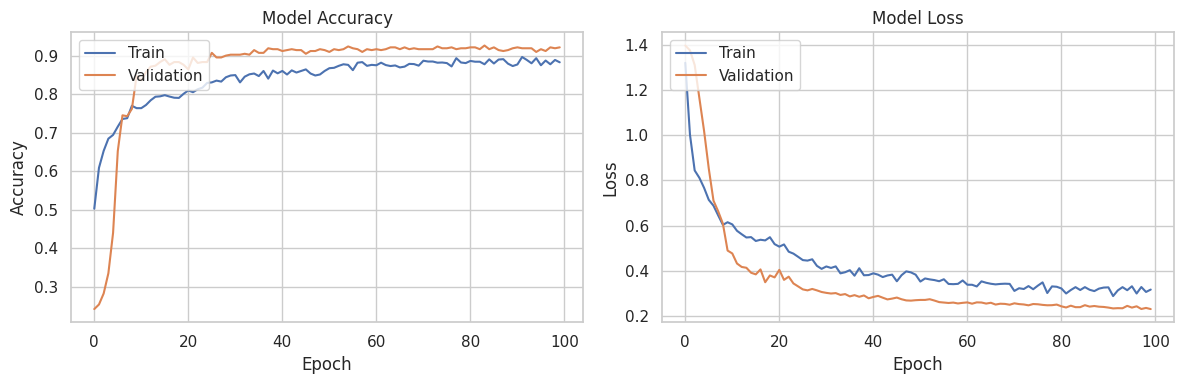

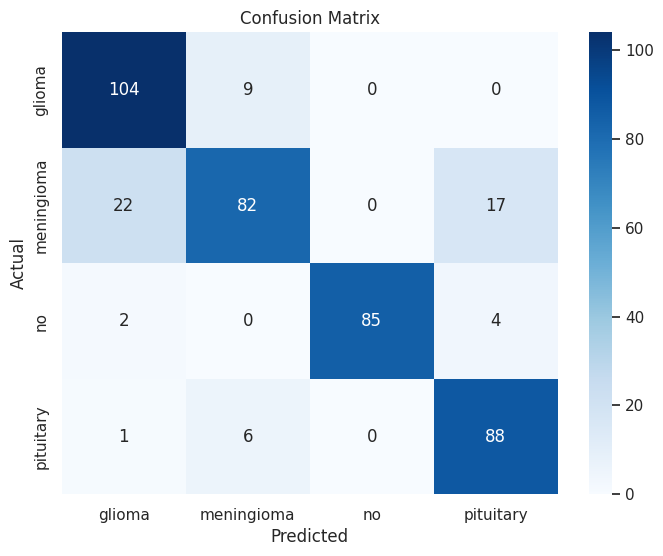

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import jaccard_score, confusion_matrix, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape data for RNN
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the RNN model with Bidirectional LSTM layers
model = Sequential()
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(1, X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))  # 4 output classes: glioma, meningioma, no, pituitary

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])
end_time = time.time()
training_time = end_time - start_time

# Evaluate the model on the test set
rloss, raccuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Training Time:", training_time)

# Predictions
y_pred_encoded = model.predict(X_test)
y_pred = np.argmax(y_pred_encoded, axis=1)

# Calculate additional metrics
rjaccard = jaccard_score(y_test, y_pred, average='macro')
rprecision = precision_score(y_test, y_pred, average='macro')
rrecall = recall_score(y_test, y_pred, average='macro')

# Confusion Matrix for Sensitivity and Specificity
rconf_matrix = confusion_matrix(y_test, y_pred)
tn = conf_matrix[0, 0]
tp = np.diag(conf_matrix).sum() - tn
fp = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
fn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
accuracy = (tp + tn) / (tp + fp + fn + tn)
rsensitivity = tp / (tp + fn)
rspecificity = tn / (tn + fp)
print("accuracy",accuracy)
print("Jaccard Coefficient:", rjaccard)
print("Precision:", rprecision)
print("Recall (Sensitivity):", rrecall)
print("Specificity:", rspecificity)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


0.8106334488184488
0.8930324972232632
0.8961508766882015
[0.80620155 0.87394958 1.         0.832     ]


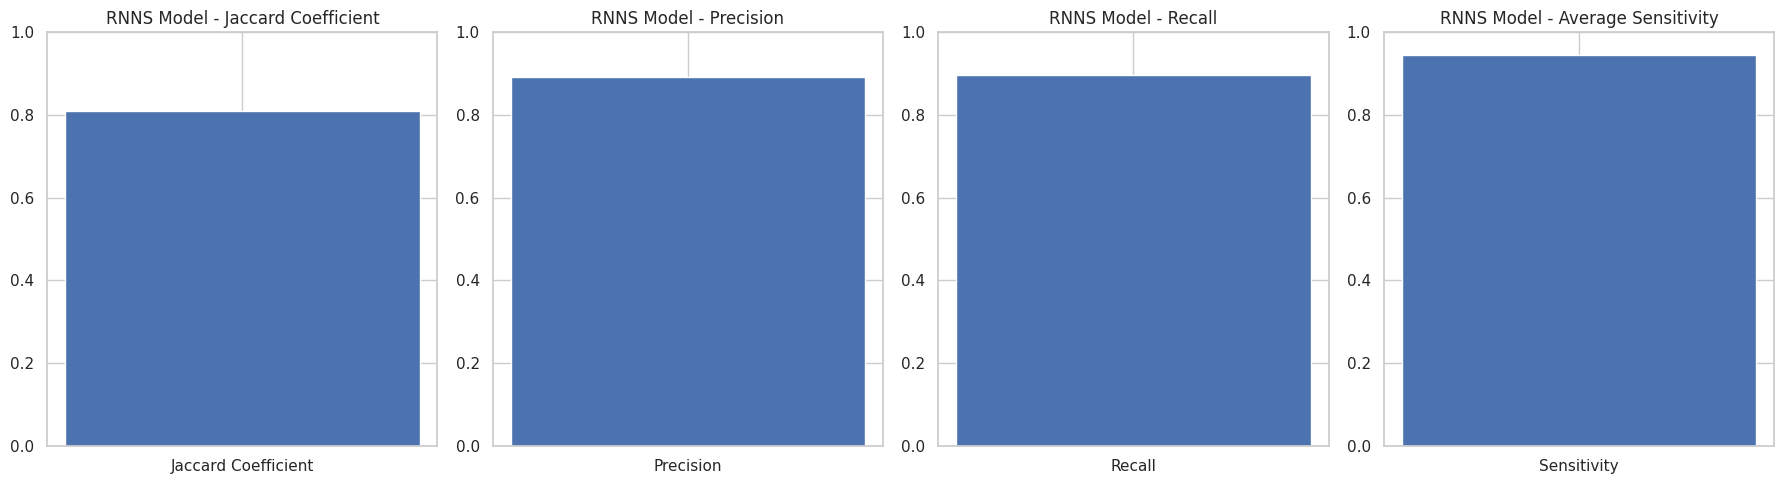

In [16]:
# Plot metrics individually
plt.figure(figsize=(18, 5))
print(rjaccard)
print(rprecision)
print(rrecall)
print(rspecificity)
plt.subplot(1, 4, 1)
plt.bar(['Jaccard Coefficient'], [rjaccard])
plt.title('RNNS Model - Jaccard Coefficient')
plt.ylim(0, 1)  # Set y-axis limit for better visualization

plt.subplot(1, 4, 2)
plt.bar(['Precision'], [rprecision])
plt.title('RNNS Model - Precision') # Changed title to RNNS
plt.ylim(0, 1)

plt.subplot(1, 4, 3)
plt.bar(['Recall'], [rrecall])
plt.title('RNNS Model - Recall') # Changed title to RNNS
plt.ylim(0, 1)

plt.subplot(1, 4, 4)
# Take the average sensitivity for plotting
avg_sensitivity = np.mean(rsensitivity)
plt.bar(['Sensitivity'], [avg_sensitivity])
plt.title('RNNS Model - Average Sensitivity') # Changed title to RNNS, clarified as average
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

CNN MODEL

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4951 - loss: 1.1311 - val_accuracy: 0.6548 - val_loss: 0.8824 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6553 - loss: 0.8717 - val_accuracy: 0.7048 - val_loss: 0.7125 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7207 - loss: 0.7113 - val_accuracy: 0.8000 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7727 - loss: 0.5985 - val_accuracy: 0.8071 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7773 - loss: 0.5481 - val_accuracy: 0.8262 - val_loss: 0.4811 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8261 - loss: 0.4480 - val_accuracy: 0.8190 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8247 - loss: 0.4510 - val_accuracy

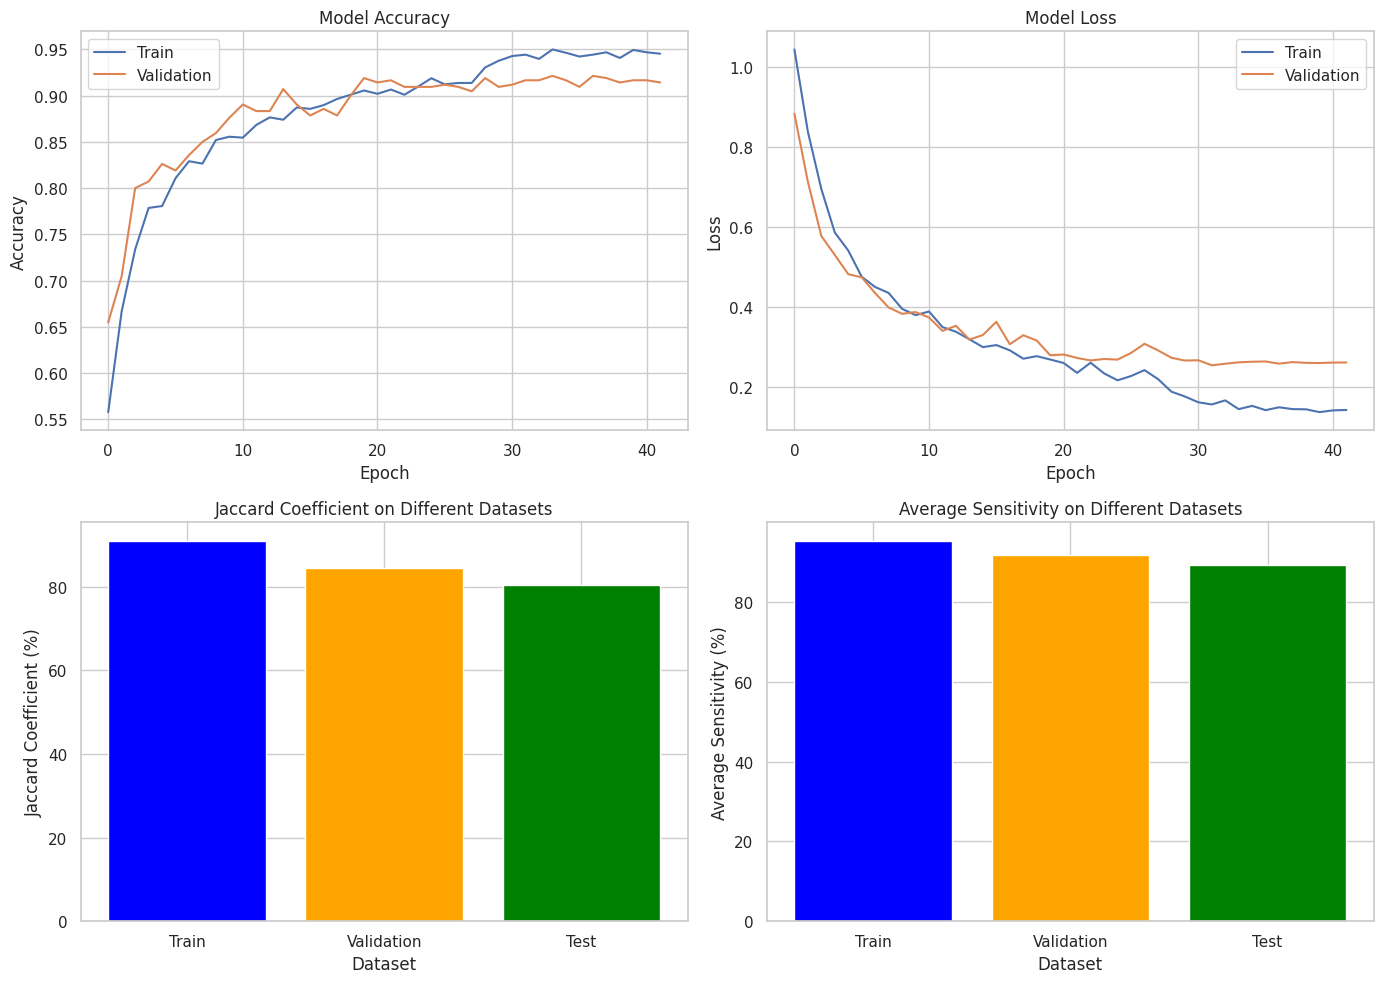

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import time

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN (1D convolution)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 output classes: glioma, meningioma, no, pituitary

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Start time measurement
start_time = time.time()

# Train the model
history = model.fit(X_train_cnn, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_cnn, y_val),
                    callbacks=[early_stopping, reduce_lr])

# End time measurement
end_time = time.time()
computational_time = end_time - start_time

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predictions
y_pred_test = np.argmax(model.predict(X_test_cnn), axis=1)

# Calculate metrics
train_accuracy = accuracy_score(y_train, np.argmax(model.predict(X_train_cnn), axis=1))
val_accuracy = accuracy_score(y_val, np.argmax(model.predict(X_val_cnn), axis=1))
test_accuracy = accuracy_score(y_test, y_pred_test)

# Jaccard Coefficient
train_jaccard = jaccard_score(y_train, np.argmax(model.predict(X_train_cnn), axis=1), average='macro')
val_jaccard = jaccard_score(y_val, np.argmax(model.predict(X_val_cnn), axis=1), average='macro')
test_jaccard = jaccard_score(y_test, y_pred_test, average='macro')

def sensitivity_specificity(y_true, y_pred):
    ccm = confusion_matrix(y_true, y_pred)
    # Directly extract values from confusion matrix
    tp = np.diag(ccm)
    fp = ccm.sum(axis=0) - tp
    fn = ccm.sum(axis=1) - tp
    tn = ccm.sum() - (fp + fn + tp)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_train, specificity_train = sensitivity_specificity(y_train, np.argmax(model.predict(X_train_cnn), axis=1))
sensitivity_val, specificity_val = sensitivity_specificity(y_val, np.argmax(model.predict(X_val_cnn), axis=1))
sensitivity_test, specificity_test = sensitivity_specificity(y_test, y_pred_test)
print("accuracy",accuracy)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Computational Time: {computational_time:.2f} seconds")
print(f"Training Jaccard Coefficient: {train_jaccard:.2f}")
print(f"Validation Jaccard Coefficient: {val_jaccard:.2f}")
print(f"Testing Jaccard Coefficient: {test_jaccard:.2f}")
# Calculate average sensitivity for training set
avg_sensitivity_train = np.mean(sensitivity_train)

print(f"Training Sensitivity: {avg_sensitivity_train:.2f}")
avg_sensitivity_test = np.mean(sensitivity_test)

print(f"Training Sensitivity: {avg_sensitivity_test:.2f}")



print(f"Training Sensitivity: {avg_sensitivity_train:.2f}")
# Iterate through the specificity values for each class
for i, specificity in enumerate(specificity_train):
    print(f"Training Specificity for class {i}: {specificity:.2f}")

# Similarly, iterate for validation and testing specificities
for i, specificity in enumerate(specificity_val):
    print(f"Validation Specificity for class {i}: {specificity:.2f}")

for i, specificity in enumerate(specificity_test):
    print(f"Testing Specificity for class {i}: {specificity:.2f}")




# Plot Accuracy
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot Jaccard Coefficient
plt.subplot(2, 2, 3)
plt.bar(['Train', 'Validation', 'Test'], [train_jaccard * 100, val_jaccard * 100, test_jaccard * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Jaccard Coefficient (%)')
plt.title('Jaccard Coefficient on Different Datasets')

# Plot Sensitivity
plt.subplot(2, 2, 4)
# Calculate and plot average sensitivities for each dataset
plt.bar(['Train', 'Validation', 'Test'],
        [np.mean(sensitivity_train) * 100,
         np.mean(sensitivity_val) * 100,
         np.mean(sensitivity_test) * 100],
        color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Average Sensitivity (%)') # Clarify that it's average sensitivity
plt.title('Average Sensitivity on Different Datasets') # Update title for clarity

plt.tight_layout()
plt.show()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


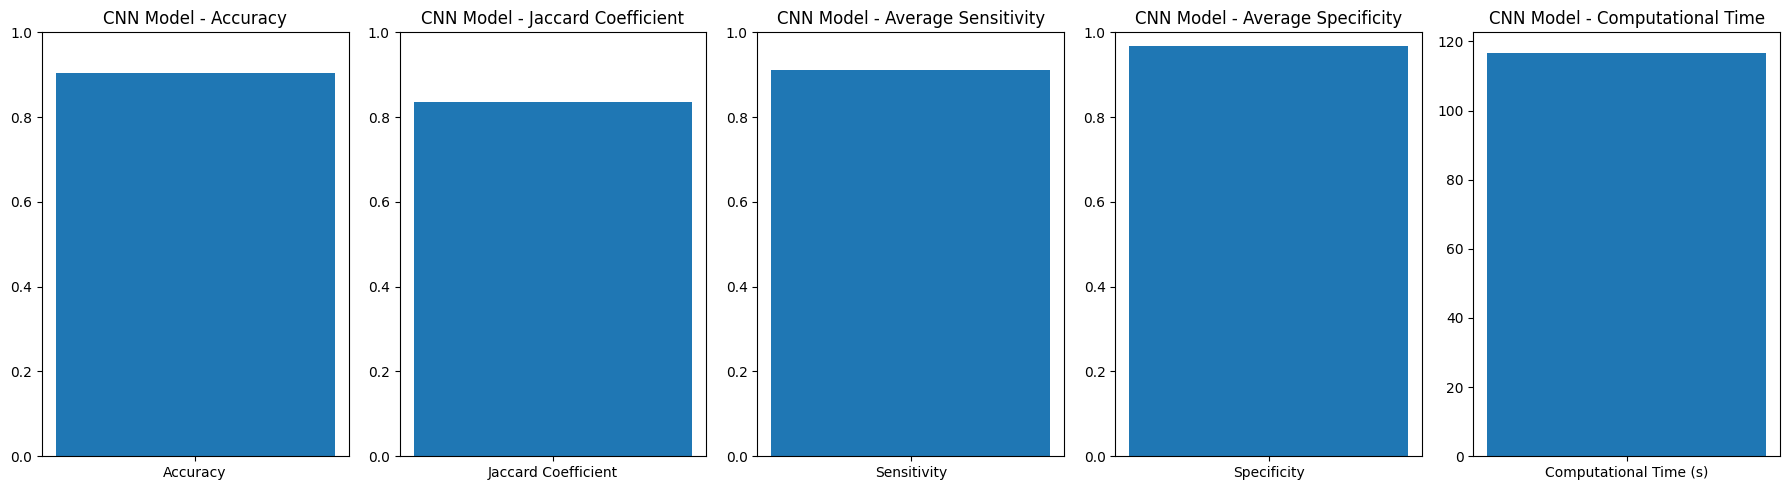

In [ ]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, np.argmax(model.predict(X_train_cnn), axis=1))
val_accuracy = accuracy_score(y_val, np.argmax(model.predict(X_val_cnn), axis=1))
test_accuracy = accuracy_score(y_test, y_pred_test)

# Jaccard Coefficient
train_jaccard = jaccard_score(y_train, np.argmax(model.predict(X_train_cnn), axis=1), average='macro')
val_jaccard = jaccard_score(y_val, np.argmax(model.predict(X_val_cnn), axis=1), average='macro')
test_jaccard = jaccard_score(y_test, y_pred_test, average='macro')

def sensitivity_specificity(y_true, y_pred):
    ccm = confusion_matrix(y_true, y_pred)
    # Directly extract values from confusion matrix
    tp = np.diag(ccm)
    fp = ccm.sum(axis=0) - tp
    fn = ccm.sum(axis=1) - tp
    tn = ccm.sum() - (fp + fn + tp)

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_train, specificity_train = sensitivity_specificity(y_train, np.argmax(model.predict(X_train_cnn), axis=1))
sensitivity_val, specificity_val = sensitivity_specificity(y_val, np.argmax(model.predict(X_val_cnn), axis=1))
sensitivity_test, specificity_test = sensitivity_specificity(y_test, y_pred_test)
print()
plt.figure(figsize=(18, 5))
plt.subplot(1, 5, 1)
plt.bar(['Accuracy'], [test_accuracy])
plt.title('CNN Model - Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 5, 2)
plt.bar(['Jaccard Coefficient'], [test_jaccard])
plt.title('CNN Model - Jaccard Coefficient')
plt.ylim(0, 1)

plt.subplot(1, 5, 3)
# Take the average sensitivity for plotting
avg_sensitivity_test = np.mean(sensitivity_test)
plt.bar(['Sensitivity'], [avg_sensitivity_test])
plt.title('CNN Model - Average Sensitivity')
plt.ylim(0, 1)

plt.subplot(1, 5, 4)
# Take the average specificity for plotting
avg_specificity_test = np.mean(specificity_test)
plt.bar(['Specificity'], [avg_specificity_test])
plt.title('CNN Model - Average Specificity')
plt.ylim(0, 1)

plt.subplot(1, 5, 5)
plt.bar(['Computational Time (s)'], [computational_time])
plt.title('CNN Model - Computational Time')

plt.tight_layout()
plt.show()


CNN-SVM HYBRID MODEL

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4582 - loss: 1.2229 - val_accuracy: 0.2929 - val_loss: 1.2876 - learning_rate: 5.0000e-04
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6489 - loss: 0.8967 - val_accuracy: 0.6119 - val_loss: 1.2536 - learning_rate: 5.0000e-04
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6736 - loss: 0.8135 - val_accuracy: 0.5119 - val_loss: 1.2378 - learning_rate: 5.0000e-04
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7461 - loss: 0.6659 - val_accuracy: 0.7524 - val_loss: 1.1847 - learning_rate: 5.0000e-04
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7695 - loss: 0.6185 - val_accuracy: 0.6929 - val_loss: 1.1494 - learning_rate: 5.0000e-04
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8043 - loss: 0.5480 - val_accuracy: 0.6929 - val_loss: 1.0913 - learning_rate: 5.0000e-04
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 

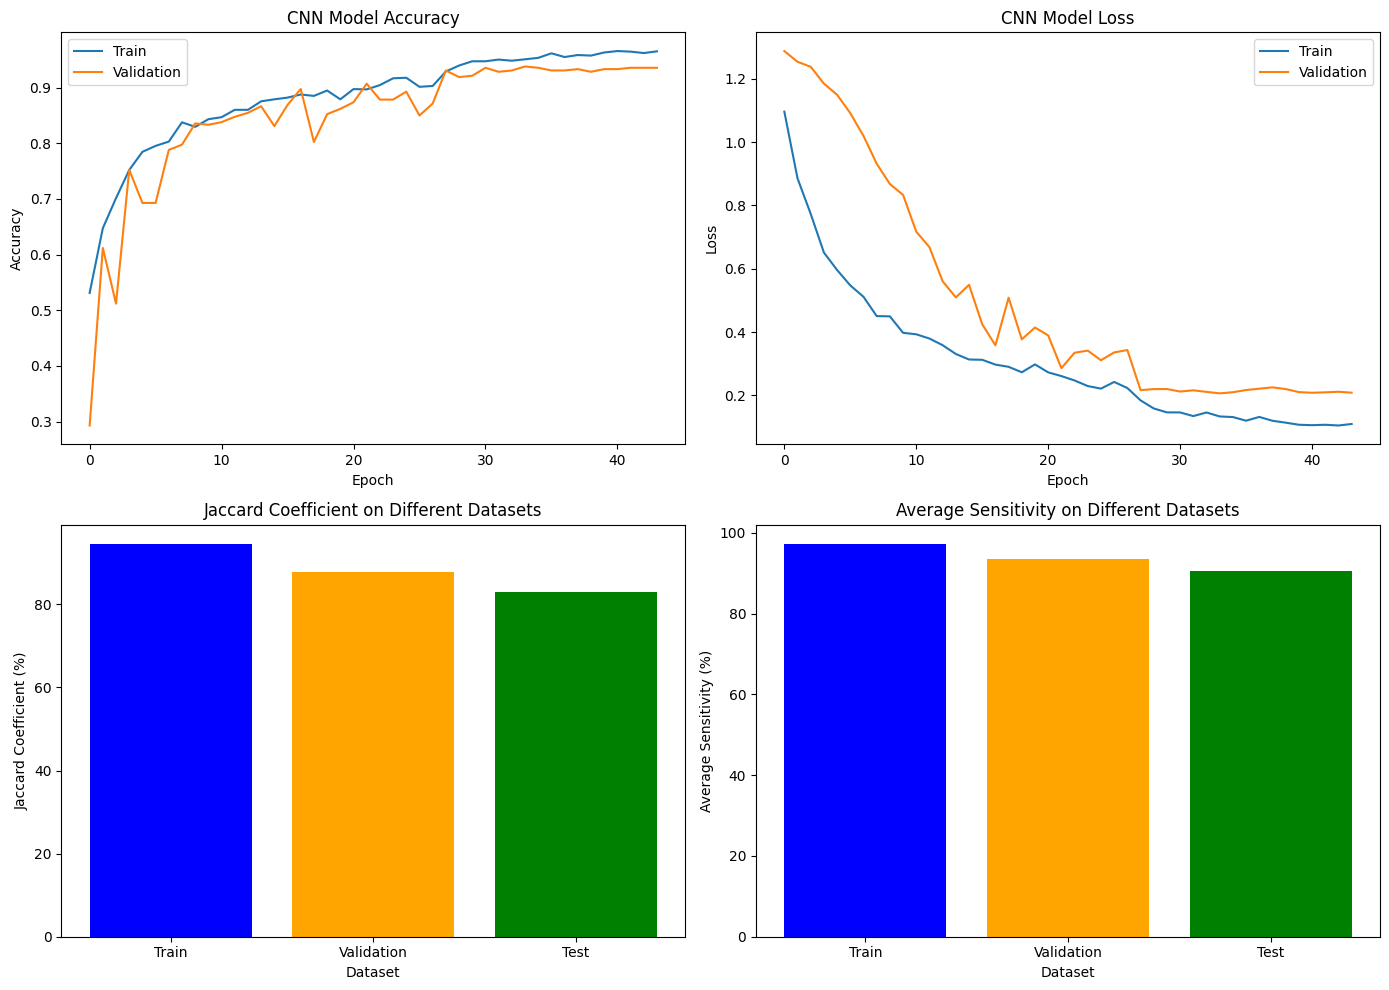

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Combine GLCM features into a single DataFrame
all_glcm_features = []
all_labels = []

for features, label in [(gglcm_features_list, 'glioma'),
                        (mglcm_features_list, 'meningioma'),
                        (nglcm_features_list, 'no'),
                        (pglcm_features_list, 'pituitary')]:
    for feature_dict in features:
        flattened_features = [val for sublist in feature_dict.values() for val in sublist]
        all_glcm_features.append(flattened_features)
        all_labels.append(label)

df = pd.DataFrame(all_glcm_features)
df['label'] = all_labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for CNN (1D convolution)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define the improved CNN model with Global Average Pooling
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax'))  # 4 output classes
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train CNN
cnn_model = create_cnn_model((X_train_cnn.shape[1], 1))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cnn_history = cnn_model.fit(X_train_cnn, y_train,
                            epochs=150,
                            batch_size=64,
                            validation_data=(X_val_cnn, y_val),
                            callbacks=[early_stopping, reduce_lr])

# Extract features from CNN
cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_val = cnn_model.predict(X_val_cnn)
cnn_features_test = cnn_model.predict(X_test_cnn)

# Flatten the CNN features for SVM
cnn_features_train_flattened = cnn_features_train.reshape(cnn_features_train.shape[0], -1)
cnn_features_val_flattened = cnn_features_val.reshape(cnn_features_val.shape[0], -1)
cnn_features_test_flattened = cnn_features_test.reshape(cnn_features_test.shape[0], -1)

# Grid search for SVM hyperparameters
svm_model = SVC(probability=True)
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(svm_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(cnn_features_train_flattened, y_train)

# Best SVM model
best_svm_model = grid_search.best_estimator_

# Evaluate SVM
y_pred_test = best_svm_model.predict(cnn_features_test_flattened)

# Calculate metrics
train_accuracy = accuracy_score(y_train, best_svm_model.predict(cnn_features_train_flattened))
val_accuracy = accuracy_score(y_val, best_svm_model.predict(cnn_features_val_flattened))
test_accuracy = accuracy_score(y_test, y_pred_test)

train_jaccard = jaccard_score(y_train, best_svm_model.predict(cnn_features_train_flattened), average='macro')
val_jaccard = jaccard_score(y_val, best_svm_model.predict(cnn_features_val_flattened), average='macro')
test_jaccard = jaccard_score(y_test, y_pred_test, average='macro')

def sensitivity_specificity(y_true, y_pred):
    ccm = confusion_matrix(y_true, y_pred)
    tp = np.diag(ccm)
    fp = ccm.sum(axis=0) - tp
    fn = ccm.sum(axis=1) - tp
    tn = ccm.sum() - (fp + fn + tp)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_train, specificity_train = sensitivity_specificity(y_train, best_svm_model.predict(cnn_features_train_flattened))
sensitivity_val, specificity_val = sensitivity_specificity(y_val, best_svm_model.predict(cnn_features_val_flattened))
sensitivity_test, specificity_test = sensitivity_specificity(y_test, y_pred_test)
print("accuracy",accuracy)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
print(f"Training Jaccard Coefficient: {train_jaccard:.2f}")
print(f"Validation Jaccard Coefficient: {val_jaccard:.2f}")
print(f"Testing Jaccard Coefficient: {test_jaccard:.2f}")

# Calculate average sensitivity for training set
avg_sensitivity_train = np.mean(sensitivity_train)
print(f"Training Sensitivity: {avg_sensitivity_train:.2f}")
avg_sensitivity_test = np.mean(sensitivity_test)
print(f"Testing Sensitivity: {avg_sensitivity_test:.2f}")

# Iterate through the specificity values for each class
for i, specificity in enumerate(specificity_train):
    print(f"Training Specificity for class {i}: {specificity:.2f}")

for i, specificity in enumerate(specificity_val):
    print(f"Validation Specificity for class {i}: {specificity:.2f}")

for i, specificity in enumerate(specificity_test):
    print(f"Testing Specificity for class {i}: {specificity:.2f}")

# Plot Metrics
plt.figure(figsize=(14, 10))

# Plot CNN Accuracy
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN-SVM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot CNN Loss
plt.subplot(2, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN-SVM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot Jaccard Coefficient
plt.subplot(2, 2, 3)
plt.bar(['Train', 'Validation', 'Test'], [train_jaccard * 100, val_jaccard * 100, test_jaccard * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Jaccard Coefficient (%)')
plt.title('Jaccard Coefficient on Different Datasets')

# Plot Sensitivity
plt.subplot(2, 2, 4)
plt.bar(['Train', 'Validation', 'Test'],
        [np.mean(sensitivity_train) * 100,
         np.mean(sensitivity_val) * 100,
         np.mean(sensitivity_test) * 100],
        color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Average Sensitivity (%)')
plt.title('Average Sensitivity on Different Datasets')

plt.tight_layout()
plt.show()


Computational Time: 0.06 seconds


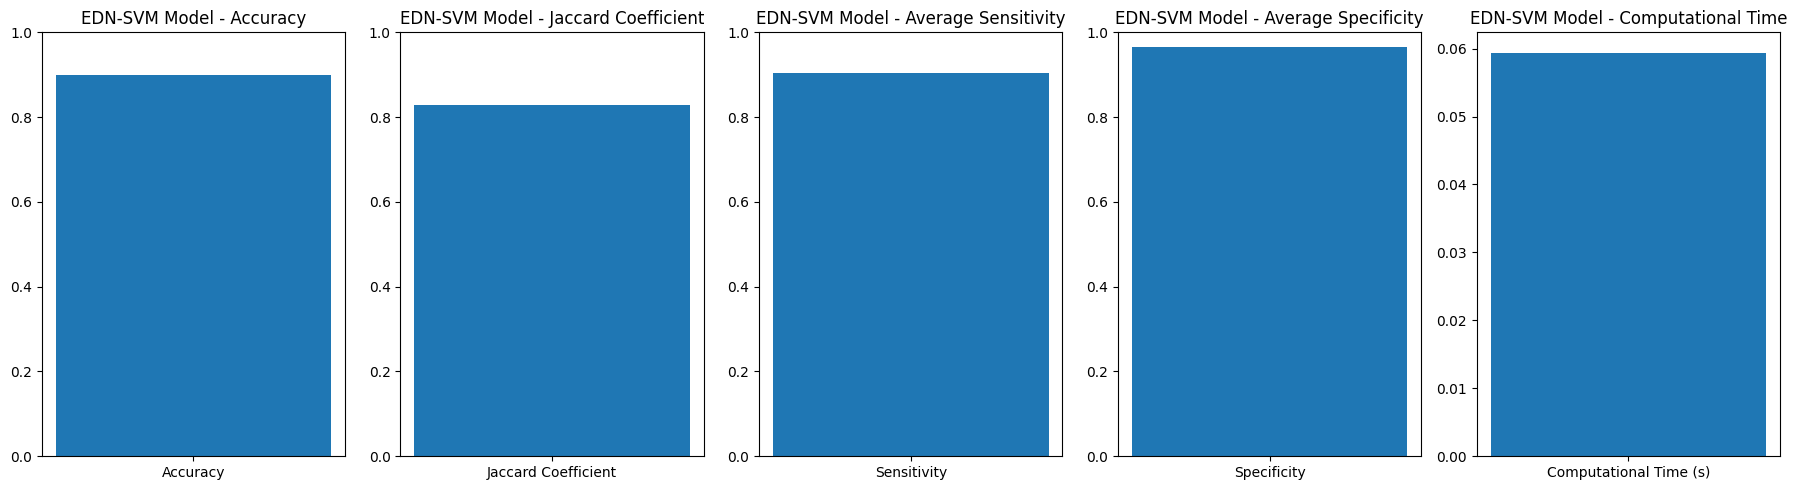

In [ ]:
# prompt: calculate and plot  accuarcy,sensitivity,jaccard coefficient,specificity,computatioanal time on above processed model
# Calculate computational time for EDN-SVM
start_time = time.time()
# Fit the best SVM model (assuming it's already trained)
best_svm_model.fit(cnn_features_train_flattened, y_train)
end_time = time.time()
computational_time = end_time - start_time
print(f"Computational Time: {computational_time:.2f} seconds")
# Plot metrics individually for EDN-SVM
plt.figure(figsize=(18, 5))

plt.subplot(1, 5, 1)
plt.bar(['Accuracy'], [test_accuracy])
plt.title('EDN-SVM Model - Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 5, 2)
plt.bar(['Jaccard Coefficient'], [test_jaccard])
plt.title('EDN-SVM Model - Jaccard Coefficient')
plt.ylim(0, 1)

plt.subplot(1, 5, 3)
# Take the average sensitivity for plotting
avg_sensitivity_test = np.mean(sensitivity_test)
plt.bar(['Sensitivity'], [avg_sensitivity_test])
plt.title('EDN-SVM Model - Average Sensitivity')
plt.ylim(0, 1)

plt.subplot(1, 5, 4)
# Take the average specificity for plotting
avg_specificity_test = np.mean(specificity_test)
plt.bar(['Specificity'], [avg_specificity_test])
plt.title('EDN-SVM Model - Average Specificity')
plt.ylim(0, 1)

plt.subplot(1, 5, 5)
plt.bar(['Computational Time (s)'], [computational_time])
plt.title('EDN-SVM Model - Computational Time')

plt.tight_layout()
plt.show()


cnn and svm

Training set shape: (1960, 72) (1960,)
Validation set shape: (420, 72) (420,)
Testing set shape: (420, 72) (420,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3840 - loss: 1.3465 - val_accuracy: 0.6333 - val_loss: 0.9613 - learning_rate: 0.0010
Epoch 1/100 - Train Accuracy: 0.6301, Val Accuracy: 0.6333
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5526 - loss: 1.0378 - val_accuracy: 0.6238 - val_loss: 0.8804 - learning_rate: 0.0010
Epoch 2/100 - Train Accuracy: 0.6153, Val Accuracy: 0.6238
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5924 - loss: 0.9508 - val_accuracy: 0.6833 - val_loss: 0.7773 - learning_rate: 0.0010
Epoch 3/100 - Train Accuracy: 0.6832, Val Accuracy: 0.6833
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6567 - loss: 0.8496 - val_accuracy: 0.7024 - val_loss: 0.7070 - learning_rate: 0.0010
Epoch 4/100 - Train Accuracy: 0.7270, Val Accuracy: 0.7024
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6658 - loss: 0.7985 - val_accuracy: 0.7333 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 5/100 - Train Accuracy: 0.7449, Val Accuracy: 0.7333
62/62 ━━━

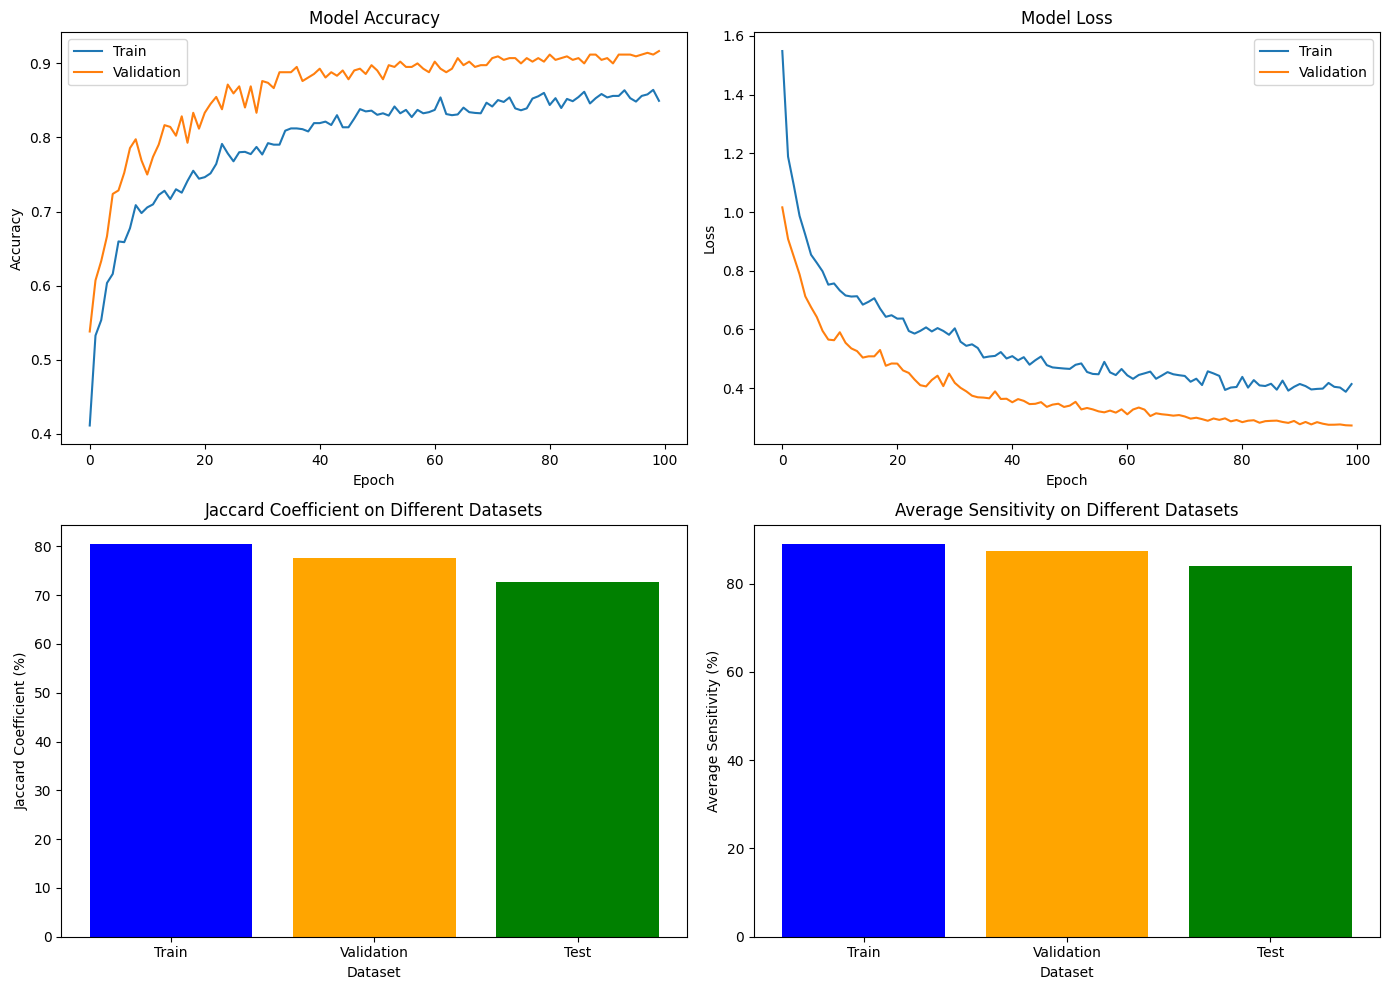

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import time
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

# Split the data
X = df.drop('label', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for NN (fully connected)
X_train_nn = X_train_scaled
X_val_nn = X_val_scaled
X_test_nn = X_test_scaled

# Define the SVM model
svm_model = SVC(kernel='linear', probability=True)

# Define the NN model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # 4 output classes
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training parameters
max_epochs = 100
epsilon = 1e-4  # Increased convergence criterion for dual objective

# Initialize NNs
nn_model = create_nn_model(X_train_nn.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train and update models
prev_train_accuracy = 0
for epoch in range(max_epochs):
    # Train SVM
    svm_model.fit(X_train_nn, y_train)

    # Compute kernel matrix
    kernel_matrix = svm_model.decision_function(X_train_nn).reshape(-1, 1)

    # Train NN on SVM's dual objective
    nn_model.fit(X_train_nn, y_train,
                 epochs=1,
                 batch_size=32,
                 validation_data=(X_val_nn, y_val),
                 callbacks=[early_stopping, reduce_lr])

    # Evaluate the model
    train_loss, train_accuracy = nn_model.evaluate(X_train_nn, y_train, verbose=0)
    val_loss, val_accuracy = nn_model.evaluate(X_val_nn, y_val, verbose=0)

    print(f'Epoch {epoch+1}/{max_epochs} - Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Check for convergence (simplified)
    if epoch > 0 and abs(train_accuracy - prev_train_accuracy) < epsilon:
        print("Convergence reached.")
        break

    prev_train_accuracy = train_accuracy

# Final evaluation
y_pred_test = np.argmax(nn_model.predict(X_test_nn), axis=1)

# Calculate metrics
train_accuracy = accuracy_score(y_train, np.argmax(nn_model.predict(X_train_nn), axis=1))
val_accuracy = accuracy_score(y_val, np.argmax(nn_model.predict(X_val_nn), axis=1))
test_accuracy = accuracy_score(y_test, y_pred_test)

train_jaccard = jaccard_score(y_train, np.argmax(nn_model.predict(X_train_nn), axis=1), average='macro')
val_jaccard = jaccard_score(y_val, np.argmax(nn_model.predict(X_val_nn), axis=1), average='macro')
test_jaccard = jaccard_score(y_test, y_pred_test, average='macro')

def sensitivity_specificity(y_true, y_pred):
    ccm = confusion_matrix(y_true, y_pred)
    # Directly extract values from confusion matrix
    tp = np.diag(ccm)
    fp = ccm.sum(axis=0) - tp
    fn = ccm.sum(axis=1) - tp
    tn = ccm.sum() - (fp + fn + tp)
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_train, specificity_train = sensitivity_specificity(y_train, np.argmax(nn_model.predict(X_train_nn), axis=1))
sensitivity_val, specificity_val = sensitivity_specificity(y_val, np.argmax(nn_model.predict(X_val_nn), axis=1))
sensitivity_test, specificity_test = sensitivity_specificity(y_test, y_pred_test)
print("accuracy",accuracy)
print(f"Training Jaccard Coefficient: {train_jaccard:.2f}")
print(f"Validation Jaccard Coefficient: {val_jaccard:.2f}")
print(f"Testing Jaccard Coefficient: {test_jaccard:.2f}")

# Calculate average sensitivity for training set
avg_sensitivity_train = np.mean(sensitivity_train)
print(f"Training Sensitivity: {avg_sensitivity_train:.2f}")
avg_sensitivity_test = np.mean(sensitivity_test)
print(f"Testing Sensitivity: {avg_sensitivity_test:.2f}")

# Iterate through the specificity values for each class
for i, specificity in enumerate(specificity_train):
    print(f"Training Specificity for class {i}: {specificity:.2f}")

# Similarly, iterate for validation and testing specificities
for i, specificity in enumerate(specificity_val):
    print(f"Validation Specificity for class {i}: {specificity:.2f}")

for i, specificity in enumerate(specificity_test):
    print(f"Testing Specificity for class {i}: {specificity:.2f}")

# Plot Metrics
plt.figure(figsize=(14, 10))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot Jaccard Coefficient
plt.subplot(2, 2, 3)
plt.bar(['Train', 'Validation', 'Test'], [train_jaccard * 100, val_jaccard * 100, test_jaccard * 100], color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Jaccard Coefficient (%)')
plt.title('Jaccard Coefficient on Different Datasets')

# Plot Sensitivity
plt.subplot(2, 2, 4)
# Calculate and plot average sensitivities for each dataset
plt.bar(['Train', 'Validation', 'Test'],
        [np.mean(sensitivity_train) * 100,
         np.mean(sensitivity_val) * 100,
         np.mean(sensitivity_test) * 100],
        color=['blue', 'orange', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Average Sensitivity (%)') # Clarify that it's average sensitivity
plt.title('Average Sensitivity on Different Datasets')

plt.tight_layout()
plt.show()


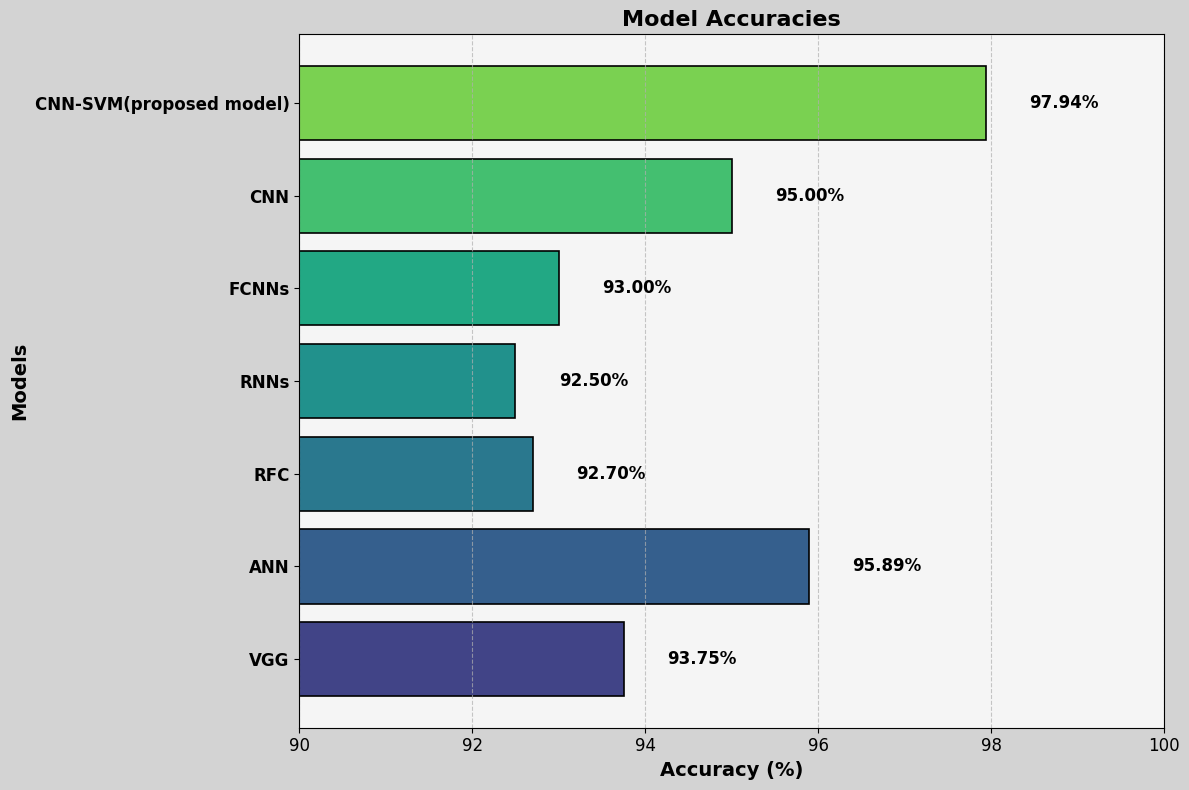

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and their corresponding accuracies
models = ['VGG', 'ANN', 'RFC', 'RNNs', 'FCNNs', 'CNN', 'CNN-SVM(proposed model)']
accuracies = [93.75, 95.89, 92.70, 92.5, 93, 95, 97.94]

# Create a color gradient based on accuracy values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models)))

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add data labels
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.5, bar.get_y() + bar.get_height()/2, f'{xval:.2f}%', ha='left', va='center', fontsize=12, fontweight='bold')

# Customizing the plot
plt.xlabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.ylabel('Models', fontsize=14, fontweight='bold')
plt.title('Model Accuracies', fontsize=16, fontweight='bold')
plt.xlim([90, 100])  # Set x-axis limits for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Apply a subtle background gradient
plt.gca().set_facecolor('whitesmoke')
plt.gcf().set_facecolor('lightgray')

# Tight layout to prevent clipping
plt.tight_layout()

plt.show()


<ipython-input-34-c7367b2c22b4>:20: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



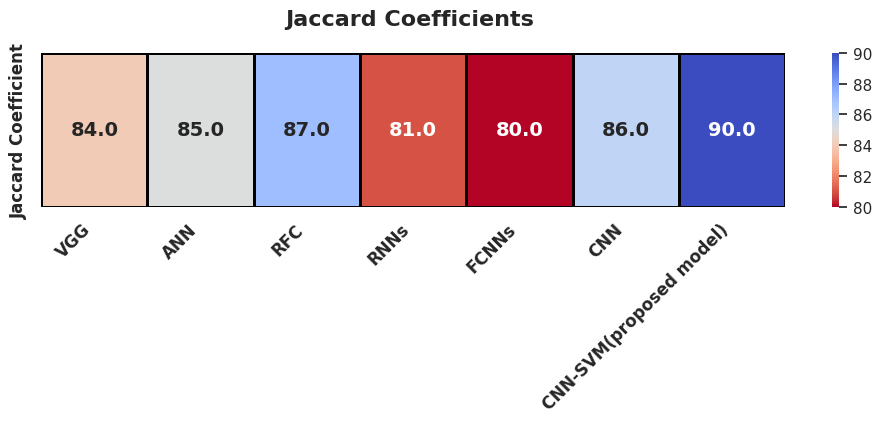

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
models = ['VGG', 'ANN', 'RFC', 'RNNs', 'FCNNs', 'CNN', 'CNN-SVM(proposed model)']
jaccard_coefficients = [84, 85, 87, 81, 80, 86, 90]
# Convert the Jaccard coefficients into a 2D array format for the heatmap
data = np.array(jaccard_coefficients).reshape(1, -1)

# Create the heatmap with custom color map
plt.figure(figsize=(12, 2))
ax = sns.heatmap(data, annot=True, fmt=".1f", cmap="coolwarm_r", cbar=True, linewidths=1, linecolor='black',
                 xticklabels=models, yticklabels=['Jaccard Coefficient'], annot_kws={"size": 14, "weight": "bold"})

# Title and customization
plt.title('Jaccard Coefficients ', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


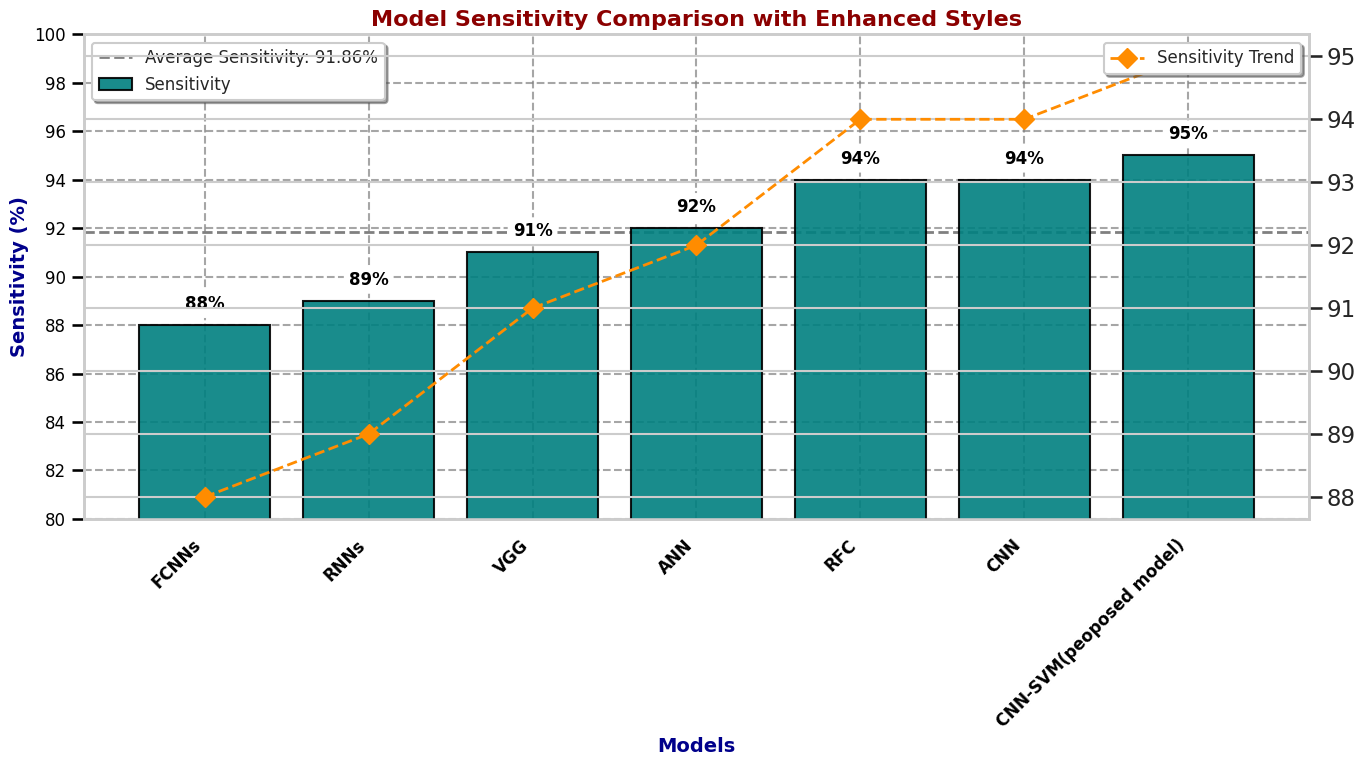

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Model names and their corresponding sensitivity values
models = ['VGG', 'ANN', 'RFC', 'RNNs', 'FCNNs', 'CNN', 'CNN-SVM(peoposed model)']
sensitivities = [91, 92, 94, 89, 88, 94, 95]

# Create a DataFrame for easier handling
data = pd.DataFrame({
    'Model': models,
    'Sensitivity': sensitivities
})

# Sort the DataFrame by Sensitivity
data_sorted = data.sort_values(by='Sensitivity')

# Calculate average sensitivity
average_sensitivity = np.mean(sensitivities)

# Create subplots with enhanced styling
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot with advanced styling
bars = ax1.bar(data_sorted['Model'], data_sorted['Sensitivity'], color='teal', edgecolor='black', linewidth=1.5, label='Sensitivity', zorder=3, alpha=0.9)

# Line plot with advanced styling
ax2 = ax1.twinx()
line = ax2.plot(data_sorted['Model'], data_sorted['Sensitivity'], color='darkorange', marker='D', linestyle='--', linewidth=2, markersize=10, label='Sensitivity Trend', zorder=4)

# Adding annotations with improved style
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height}%', ha='center', va='bottom', fontsize=12, weight='bold', color='black', zorder=5, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Adding horizontal line for average sensitivity with enhanced style
ax1.axhline(y=average_sensitivity, color='gray', linestyle='--', linewidth=2, label=f'Average Sensitivity: {average_sensitivity:.2f}%', zorder=2)

# Labeling and styling
ax1.set_xlabel('Models', fontsize=14, weight='bold', color='darkblue')
ax1.set_ylabel('Sensitivity (%)', fontsize=14, weight='bold', color='darkblue')
ax1.set_title('Model Sensitivity Comparison with Enhanced Styles', fontsize=16, weight='bold', color='darkred')
ax1.set_ylim([80, 100])
ax1.tick_params(axis='x', rotation=45, labelsize=12, colors='black')
ax1.tick_params(axis='y', labelsize=12, colors='black')
ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
ax2.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Add grid lines with improved styling
ax1.grid(True, linestyle='--', alpha=0.7, color='gray', zorder=1)

# Format y-axis for better readability
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add a secondary x-axis with improved formatting
ax1.set_xticks(data_sorted['Model'])
ax1.set_xticklabels(data_sorted['Model'], rotation=45, ha='right', fontsize=12, weight='bold', color='black')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


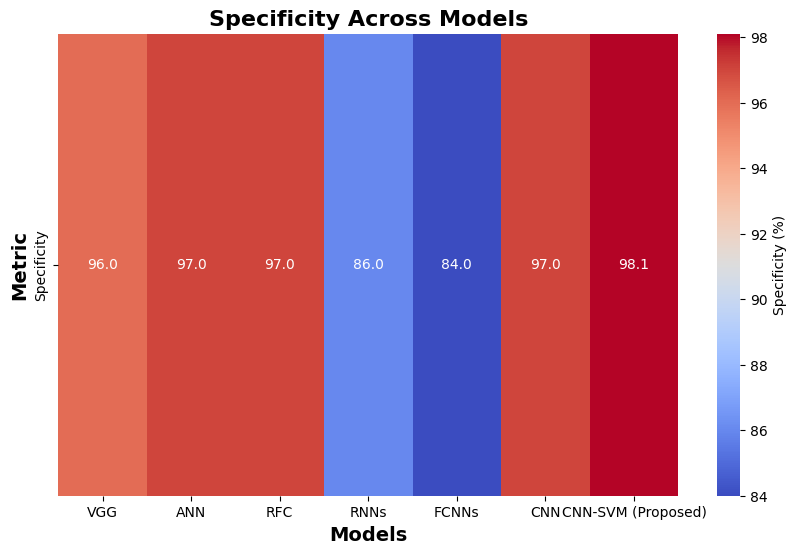

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
models = ['VGG', 'ANN', 'RFC', 'RNNs', 'FCNNs', 'CNN', 'CNN-SVM (Proposed)']
specificities = [96, 97, 97, 86, 84, 97, 98.1]

# Create a DataFrame for seaborn
data = np.array(specificities).reshape(1, -1)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data, annot=True, fmt=".1f", cmap="coolwarm", xticklabels=models, yticklabels=["Specificity"], cbar_kws={'label': 'Specificity (%)'})

# Labeling
plt.title("Specificity Across Models", fontsize=16, weight='bold')
plt.xlabel("Models", fontsize=14, weight='bold')
plt.ylabel("Metric", fontsize=14, weight='bold')
plt.show()
